ISE537 Final Project - Price Prediction: Comparison between ARIMA Model and LSTM

Student: Yu Yun Tsai

USCID:1022494450

#### 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# plt.style.use("fivethirtyeight")
# sns.set_style('whitegrid')
# %matplotlib inline
plt.rcParams.update({'font.size': 15})
# For reading stock data from yahoo
from pandas_datareader.data import DataReader

# For time stamps
from datetime import datetime
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf , pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import arma_order_select_ic
import statsmodels.tsa.stattools as sm_tools
import scipy.stats as stats
import statsmodels.api as sm
import math as m
import scipy as sp
from statsmodels.stats.anova import anova_lm

Using TensorFlow backend.


In [2]:
plt.rcParams.update({'font.size': 15})

• Lecture Notes 11-13 and 21-22 and Jupyter Notebooks (“Lec 10-11 Time Series,” “Lec12-13 Time Series.ipynb,”  “Lectures 21-22: Deep Learning,” and “Lecture 22 Stock Price Prediction using LSTM”) are related to this project.

• Choose two stocks as you wish for the prediction. Do predictions separately for each stock.

• Pick a period (explain why) and use daily close price from Yahoo Finance for the prediction.

• Show evidence of convergence for the LSTM model and explain how you pick the lags for the ARIMA model.

• Compare the out-of-sample performance between ARIMA Model and LSTM.

• Explain the pros and cons of both methods. Any difference between the performances
of the two stocks you pick?

In [3]:
#Download Data

In [4]:
# The tech stocks we'll use for this analysis
tech_list = ['AAL', 'DAL']

# Set up End and Start times for data grab
end = '2022-06-12'
start = '2020-01-01'

#For loop for grabing yahoo finance data and setting as a dataframe
for stock in tech_list:   
    # Set DataFrame as the Stock Ticker
    globals()[stock] = yf.download(stock,  start, end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
company_list = [AAL, DAL]
company_name = ['Ameriacan Airlines', 'Delta Airlines']

for company, com_name in zip(company_list, company_name):
    company['company_name'] = com_name
    
df = pd.concat(company_list, axis=0)
df.tail(10)

,Open,High,Low,Close,Adj Close,Volume,company_name
Date,,,,,,,
2022-05-27,41.000000,42.230000,41.000000,42.230000,42.230000,10730600,Delta Airlines
2022-05-31,40.709999,42.450001,40.580002,41.689999,41.689999,14691200,Delta Airlines
2022-06-01,42.130001,42.299999,39.230000,39.540001,39.540001,17573200,Delta Airlines
2022-06-02,39.400002,40.290001,39.220001,39.990002,39.990002,13761600,Delta Airlines
2022-06-03,39.200001,39.419998,38.060001,38.540001,38.540001,14804300,Delta Airlines
2022-06-06,39.000000,39.290001,38.310001,39.000000,39.000000,12330400,Delta Airlines
2022-06-07,38.369999,39.790001,38.250000,39.740002,39.740002,9604700,Delta Airlines
2022-06-08,38.840000,39.529999,38.169998,38.220001,38.220001,9643000,Delta Airlines
2022-06-09,38.099998,38.209999,36.709999,36.750000,36.750000,11976600,Delta Airlines


In [6]:
AAL.describe()

,Open,High,Low,Close,Adj Close,Volume
count,616.000000,616.000000,616.000000,616.000000,616.000000,6.160000e+02
mean,17.770455,18.195162,17.289578,17.708230,17.704608,5.097149e+07
std,4.606609,4.607063,4.588385,4.612064,4.604345,3.868580e+07
min,8.770000,9.190000,8.250000,9.040000,9.040000,5.524800e+06
25%,13.597500,14.287500,13.095000,13.605000,13.605000,2.950272e+07
50%,17.675000,18.170000,17.195000,17.620000,17.620000,4.127930e+07
75%,20.802501,21.315000,20.309999,20.637499,20.637499,6.116170e+07
max,30.030001,30.780001,29.990000,30.469999,30.469999,4.286171e+08


In [7]:
AAL.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 616 entries, 2020-01-02 to 2022-06-10
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          616 non-null    float64
 1   High          616 non-null    float64
 2   Low           616 non-null    float64
 3   Close         616 non-null    float64
 4   Adj Close     616 non-null    float64
 5   Volume        616 non-null    int64  
 6   company_name  616 non-null    object 
dtypes: float64(5), int64(1), object(1)
memory usage: 38.5+ KB


In [8]:
#Visualize Data

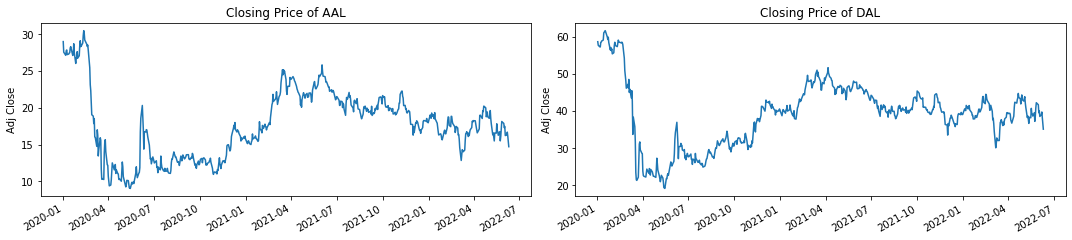

In [9]:
plt.figure(figsize=(15, 6))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Adj Close'].plot()
    plt.ylabel('Adj Close')
    plt.xlabel(None)
    plt.title(f"Closing Price of {tech_list[i - 1]}")
    
plt.tight_layout()

##Prediction using LSTM for stock Ameriacan Airlines(AAL)

In [10]:
# Get the stock quote od stock AAL
df_aal = yf.download('AAL',  start='2020-01-01', end='2022-06-12')
# Show teh data
df_aal

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,28.980000,29.299999,28.650000,29.090000,28.982893,6451100
2020-01-03,28.270000,28.290001,27.340000,27.650000,27.548195,14008900
2020-01-06,27.190001,27.490000,27.080000,27.320000,27.219410,6105800
2020-01-07,27.559999,27.680000,27.059999,27.219999,27.119778,6105900
2020-01-08,27.100000,28.090000,27.070000,27.840000,27.737495,10496800
...,...,...,...,...,...,...
2022-06-06,16.530001,16.570000,16.020000,16.299999,16.299999,29567800
2022-06-07,16.100000,16.730000,15.960000,16.690001,16.690001,29278100
2022-06-08,16.389999,16.690001,16.110001,16.150000,16.150000,22558800


In [11]:
# Create a new dataframe with only the 'Close Price' column 
data_aal = df_aal.filter(['Close'])
# Convert the dataframe to a numpy array(number series)
dataset_aal = data_aal.values
# Get the number of rows to train the model on
training_data_len_aal = int(np.ceil( len(dataset_aal) * .95 ))

training_data_len_aal

586

In [12]:
# Scale the data to interval[0,1]
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data_aal = scaler.fit_transform(dataset_aal)

scaled_data_aal

array([[0.93560433],
       [0.86840878],
       [0.85300981],
       [0.84834344],
       [0.87727488],
       [0.8824079 ],
       [0.85300981],
       [0.85627625],
       [0.86280921],
       [0.86514235],
       [0.89547364],
       [0.90340645],
       [0.84741024],
       [0.85300981],
       [0.92207186],
       [0.86794214],
       [0.79654695],
       [0.83341112],
       [0.82874474],
       [0.87167522],
       [0.83061133],
       [0.84554365],
       [0.90480639],
       [0.93607098],
       [0.89874008],
       [0.90247316],
       [0.9216053 ],
       [0.970602  ],
       [1.        ],
       [0.98226789],
       [0.94073735],
       [0.91413905],
       [0.90014002],
       [0.90853947],
       [0.87634159],
       [0.76574901],
       [0.65702293],
       [0.61922538],
       [0.53943074],
       [0.46710217],
       [0.45823616],
       [0.41110596],
       [0.44283719],
       [0.32664494],
       [0.32337847],
       [0.26644891],
       [0.37144192],
       [0.336

In [13]:
scaled_data_aal.shape

(616, 1)

In [14]:
# Create the training data set 
# Create the scaled training data set
train_data_aal = scaled_data_aal[0:int(training_data_len_aal), :]
# Split the data into x_train and y_train data sets
x_train_aal = []
y_train_aal = []

for i in range(60, len(train_data_aal)):
    x_train_aal.append(train_data_aal[i-60:i, 0])
    y_train_aal.append(train_data_aal[i, 0])
    if i<= 61:
        print(x_train_aal)
        print(y_train_aal)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train_aal, y_train_aal = np.array(x_train_aal), np.array(y_train_aal)

# Reshape the data
x_train_aal = np.reshape(x_train_aal, (x_train_aal.shape[0], x_train_aal.shape[1], 1))
# x_train.shape

[array([0.93560433, 0.86840878, 0.85300981, 0.84834344, 0.87727488,
       0.8824079 , 0.85300981, 0.85627625, 0.86280921, 0.86514235,
       0.89547364, 0.90340645, 0.84741024, 0.85300981, 0.92207186,
       0.86794214, 0.79654695, 0.83341112, 0.82874474, 0.87167522,
       0.83061133, 0.84554365, 0.90480639, 0.93607098, 0.89874008,
       0.90247316, 0.9216053 , 0.970602  , 1.        , 0.98226789,
       0.94073735, 0.91413905, 0.90014002, 0.90853947, 0.87634159,
       0.76574901, 0.65702293, 0.61922538, 0.53943074, 0.46710217,
       0.45823616, 0.41110596, 0.44283719, 0.32664494, 0.32337847,
       0.26644891, 0.37144192, 0.3369109 , 0.20578628, 0.24591697,
       0.32104528, 0.30517966, 0.12179187, 0.05832945, 0.06252917,
       0.05646291, 0.22771816, 0.29631361, 0.30891274, 0.23331779])]
[0.14979002031197303]

[array([0.93560433, 0.86840878, 0.85300981, 0.84834344, 0.87727488,
       0.8824079 , 0.85300981, 0.85627625, 0.86280921, 0.86514235,
       0.89547364, 0.90340645, 0.84

In [15]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train_aal.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
his_aal = model.fit(x_train_aal, y_train_aal, batch_size=1, epochs=20).history
his_aal

2022-12-11 23:07:48.153595: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-11 23:07:48.153995: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/20
526/526 [==============================] - 80s 152ms/step - loss: 0.0072
Epoch 2/20
526/526 [==============================] - 79s 150ms/step - loss: 0.0034
Epoch 3/20
526/526 [==============================] - 80s 151ms/step - loss: 0.0023
Epoch 4/20
526/526 [==============================] - 78s 148ms/step - loss: 0.0019
Epoch 5/20
526/526 [==============================] - 77s 147ms/step - loss: 0.0015
Epoch 6/20
526/526 [==============================] - 78s 148ms/step - loss: 0.0014
Epoch 7/20
526/526 [==============================] - 77s 147ms/step - loss: 0.0014
Epoch 8/20
526/526 [==============================] - 77s 147ms/step - loss: 0.0015
Epoch 9/20
526/526 [==============================] - 78s 149ms/step - loss: 0.0014
Epoch 10/20
526/526 [==============================] - 77s 147ms/step - loss: 0.0013
Epoch 11/20
526/526 [==============================] - 78s 148ms/step - loss: 0.0014
Epoch 12/20
526/526 [==============================] - 81s 154ms/step - lo

{'loss': [0.007171550107458657,
  0.003390455198134016,
  0.002323589153847569,
  0.0018946276976698785,
  0.0015007231165188224,
  0.0013900416399760974,
  0.001415529844540829,
  0.0014831370191354897,
  0.0014326114432078737,
  0.0013359894597267201,
  0.0013894260735676876,
  0.00150575289436721,
  0.0012911991914839084,
  0.001436275310846566,
  0.0012602335929719237,
  0.001347746362168632,
  0.0012976371159971077,
  0.0012693833799045891,
  0.0013929028404877726,
  0.001309915604278465]}

In [16]:
#Create a testing set
test_data_aal = scaled_data_aal[training_data_len_aal - 60: , :]
# Create the data sets x_test and y_test
x_test_aal = []
y_test_aal = dataset_aal[training_data_len_aal:, :]
for i in range(60, len(test_data_aal)):
    x_test_aal.append(test_data_aal[i-60:i, 0])
    
# Convert the data to a numpy array
x_test_aal = np.array(x_test_aal)

# Reshape the data
x_test_aal = np.reshape(x_test_aal, (x_test_aal.shape[0], x_test_aal.shape[1], 1 ))

In [17]:
# Get the models predicted price values 
predictions_aal = model.predict(x_test_aal)
predictions_aal = scaler.inverse_transform(predictions_aal)

# Get the root mean squared error (RMSE) of testing data
rmse_aal = np.sqrt(np.mean(((predictions_aal - y_test_aal) ** 2)))
rmse_aal

0.8321273667458955

In [18]:
# Get the models predicted price values 
predictions_train_aal = model.predict(x_train_aal)
predictions_train_aal = scaler.inverse_transform(predictions_train_aal)

y_train_transfer_aal = np.reshape(y_train_aal, (-1,1))
y_train_transfer_aal = scaler.inverse_transform(y_train_transfer_aal)
# Get the root mean squared error (RMSE) of training data
rmse_train_aal = np.sqrt(np.mean(((predictions_train_aal - y_train_transfer_aal) ** 2)))
rmse_train_aal

0.9160982840442262

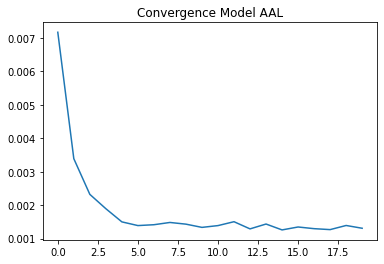

In [19]:
#LSTM convergence
plt.plot(his_aal['loss'])
plt.title('Convergence Model AAL')
plt.show()

/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


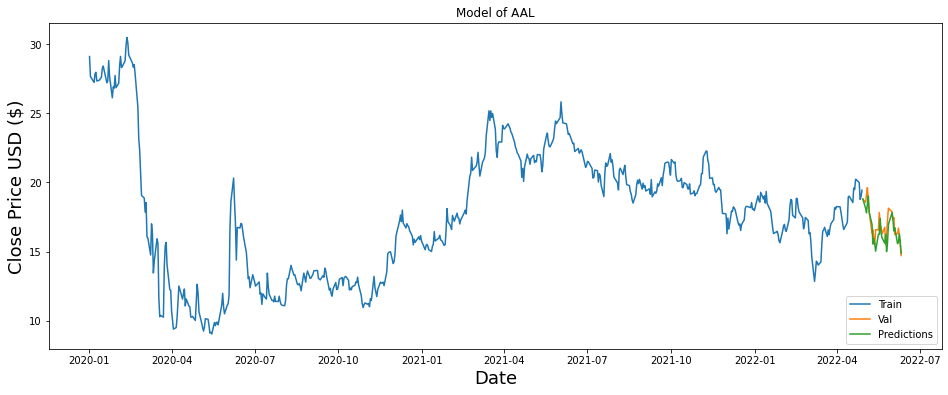

In [20]:
train_aal = df_aal[:training_data_len_aal]
valid_aal = df_aal[training_data_len_aal:]
valid_aal['Predictions'] = predictions_aal
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model of AAL')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train_aal['Close'], linewidth =1.5)
plt.plot(valid_aal[['Close', 'Predictions']], linewidth =1.5)
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

# Prediction using LSTM for stock Delta Airlines(DAL)

In [21]:
#Download data
# Get the stock quote of Delta Airlines
df_delta = yf.download('DAL',  start='2020-01-01', end='2022-06-12')
# Show teh data
df_delta

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,58.930000,59.389999,58.450001,59.040001,58.634808,4459200
2020-01-03,57.500000,58.119999,56.910000,58.060001,57.661533,9078100
2020-01-06,56.990002,57.759998,56.660000,57.660000,57.264275,5504300
2020-01-07,57.910000,58.070000,57.470001,57.610001,57.214619,5563000
2020-01-08,57.750000,59.400002,57.730000,58.849998,58.446106,8519000
...,...,...,...,...,...,...
2022-06-06,39.000000,39.290001,38.310001,39.000000,39.000000,12330400
2022-06-07,38.369999,39.790001,38.250000,39.740002,39.740002,9604700
2022-06-08,38.840000,39.529999,38.169998,38.220001,38.220001,9643000


In [22]:
# Create a new dataframe with only the 'Close column 
data_delta = df_delta.filter(['Close'])
# Convert the dataframe to a numpy array
dataset_delta = data_delta.values
# Get the number of rows to train the model on
training_data_len_delta = int(np.ceil( len(dataset_delta) * .95 ))

training_data_len_delta

586

In [23]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data_delta = scaler.fit_transform(dataset_delta)

scaled_data_delta

array([[0.93020546],
       [0.90732966],
       [0.89799255],
       [0.89682544],
       [0.9257703 ],
       [0.92833801],
       [0.93487401],
       [0.94070968],
       [0.9864613 ],
       [0.99042951],
       [0.99649865],
       [1.        ],
       [0.96055092],
       [0.94421103],
       [0.95891694],
       [0.92483666],
       [0.87861818],
       [0.89379086],
       [0.87441649],
       [0.88492062],
       [0.85317466],
       [0.86017745],
       [0.90429508],
       [0.92670403],
       [0.91013075],
       [0.90406161],
       [0.89915967],
       [0.92133522],
       [0.94024282],
       [0.93230631],
       [0.9269375 ],
       [0.92273581],
       [0.91783379],
       [0.9147993 ],
       [0.90289449],
       [0.81792718],
       [0.73996266],
       [0.7096172 ],
       [0.67693742],
       [0.62885158],
       [0.6528945 ],
       [0.63001869],
       [0.68417369],
       [0.60270772],
       [0.6232493 ],
       [0.56792719],
       [0.61344542],
       [0.548

In [24]:
# Create a new dataframe with only the 'Close column 
data_delta = df_delta.filter(['Close'])
# Convert the dataframe to a numpy array
dataset_delta = data_delta.values
# Get the number of rows to train the model on
training_data_len_delta = int(np.ceil( len(dataset_delta) * .95 ))

training_data_len_delta

586

In [25]:
# Create the training data set 
# Create the scaled training data set
train_data_delta = scaled_data_delta[0:int(training_data_len_delta), :]
# Split the data into x_train and y_train data sets
x_train_delta = []
y_train_delta = []

for i in range(60, len(train_data_delta)):
    x_train_delta.append(train_data_delta[i-60:i, 0])
    y_train_delta.append(train_data_delta[i, 0])
    if i<= 61:
        print(x_train_delta)
        print(y_train_delta)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train_delta, y_train_delta = np.array(x_train_delta), np.array(y_train_delta)

# Reshape the data
x_train_delta = np.reshape(x_train_delta, (x_train_delta.shape[0], x_train_delta.shape[1], 1))
# x_train.shape

[array([0.93020546, 0.90732966, 0.89799255, 0.89682544, 0.9257703 ,
       0.92833801, 0.93487401, 0.94070968, 0.9864613 , 0.99042951,
       0.99649865, 1.        , 0.96055092, 0.94421103, 0.95891694,
       0.92483666, 0.87861818, 0.89379086, 0.87441649, 0.88492062,
       0.85317466, 0.86017745, 0.90429508, 0.92670403, 0.91013075,
       0.90406161, 0.89915967, 0.92133522, 0.94024282, 0.93230631,
       0.9269375 , 0.92273581, 0.91783379, 0.9147993 , 0.90289449,
       0.81792718, 0.73996266, 0.7096172 , 0.67693742, 0.62885158,
       0.6528945 , 0.63001869, 0.68417369, 0.60270772, 0.6232493 ,
       0.56792719, 0.61344542, 0.54808587, 0.33893555, 0.44747901,
       0.38795522, 0.29295051, 0.10037347, 0.05415499, 0.05042017,
       0.07072827, 0.17973854, 0.27801121, 0.29201682, 0.24183004])]
[0.22128851378489084]

[array([0.93020546, 0.90732966, 0.89799255, 0.89682544, 0.9257703 ,
       0.92833801, 0.93487401, 0.94070968, 0.9864613 , 0.99042951,
       0.99649865, 1.        , 0.96

In [26]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train_delta.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
his_delta = model.fit(x_train_delta, y_train_delta, batch_size=1, epochs=20).history
his_delta

Epoch 1/20
526/526 [==============================] - 83s 157ms/step - loss: 0.0043
Epoch 2/20
526/526 [==============================] - 80s 151ms/step - loss: 0.0021
Epoch 3/20
526/526 [==============================] - 76s 145ms/step - loss: 0.0017
Epoch 4/20
526/526 [==============================] - 75s 143ms/step - loss: 0.0013
Epoch 5/20
526/526 [==============================] - 77s 145ms/step - loss: 0.0012
Epoch 6/20
526/526 [==============================] - 76s 145ms/step - loss: 0.0010
Epoch 7/20
526/526 [==============================] - 76s 145ms/step - loss: 0.0012
Epoch 8/20
526/526 [==============================] - 75s 143ms/step - loss: 0.0011
Epoch 9/20
526/526 [==============================] - 76s 144ms/step - loss: 0.0011
Epoch 10/20
526/526 [==============================] - 76s 145ms/step - loss: 0.0011
Epoch 11/20
526/526 [==============================] - 76s 144ms/step - loss: 0.0011
Epoch 12/20
526/526 [==============================] - 76s 144ms/step - lo

{'loss': [0.004303079512882673,
  0.002070961671457475,
  0.0017268409562644746,
  0.0012652259216056115,
  0.0012273835426958098,
  0.0010220431037437849,
  0.0011745465759295294,
  0.0010904807829089035,
  0.0010734418973783913,
  0.0010657655306162354,
  0.0011037795175770095,
  0.0010151155524682843,
  0.0009940082073577813,
  0.0010687628111989212,
  0.0009946782770502132,
  0.0010078884431279896,
  0.0009918720503521,
  0.0009954169051495036,
  0.001019443906333379,
  0.0010272989272479278]}

In [27]:
# Create the testing data set
test_data_delta = scaled_data_delta[training_data_len_delta - 60: , :]
# Create the data sets x_test and y_test
x_test_delta = []
y_test_delta = dataset_delta[training_data_len_delta:, :]
for i in range(60, len(test_data_delta)):
    x_test_delta.append(test_data_delta[i-60:i, 0])
    
# Convert the data to a numpy array
x_test_delta = np.array(x_test_delta)

# Reshape the data
x_test_delta = np.reshape(x_test_delta, (x_test_delta.shape[0], x_test_delta.shape[1], 1 ))

# Get the models predicted price values 
predictions_delta = model.predict(x_test_delta)
predictions_delta = scaler.inverse_transform(predictions_delta)

In [28]:
# Get the root mean squared error (RMSE) of testing data
rmse_delta = np.sqrt(np.mean(((predictions_delta - y_test_delta) ** 2)))
rmse_delta

1.4572247208008595

In [29]:
# Get the models predicted price values 
predictions_train_delta = model.predict(x_train_delta)
predictions_train_delta = scaler.inverse_transform(predictions_train_delta)

y_train_transfer_delta = np.reshape(y_train_delta, (-1,1))
y_train_transfer_delta = scaler.inverse_transform(y_train_transfer_delta)

# Get the root mean squared error (RMSE) of training data
rmse_train_delta = np.sqrt(np.mean(((predictions_train_delta - y_train_transfer_delta) ** 2)))
rmse_train_delta

1.1743024003319495

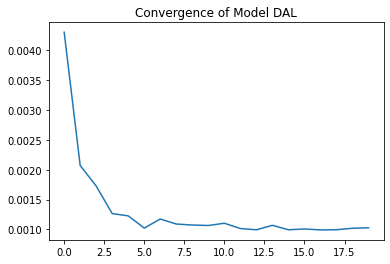

In [30]:
plt.plot(his_delta['loss'])
plt.title('Convergence of Model DAL')
plt.show()

/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


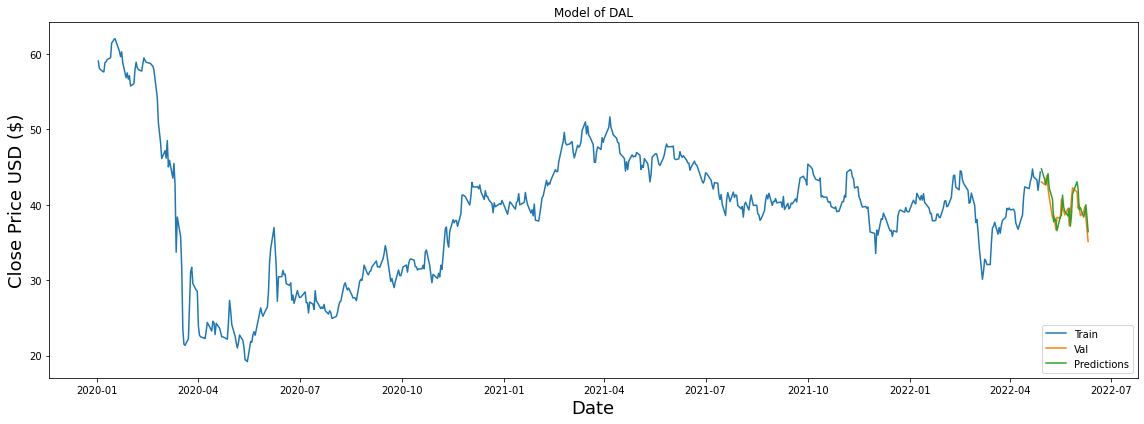

In [31]:
train_delta = df_delta[:training_data_len_delta]
valid_delta = df_delta[training_data_len_delta:]
valid_delta['Predictions'] = predictions_delta
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model of DAL')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train_delta['Close'], linewidth =1.5)
plt.plot(valid_delta[['Close', 'Predictions']], linewidth = 1.5)
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.tight_layout()
plt.savefig('LSTM_dal.png', dpi = 500)
plt.show()

# Prediction using ARIMA Model for stock American Airlines(AAL)

In [32]:
# Get the stock quote
df_aal = yf.download('AAL',  start='2020-01-01', end='2022-06-12')
# Show teh data
df_aal

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,28.980000,29.299999,28.650000,29.090000,28.982893,6451100
2020-01-03,28.270000,28.290001,27.340000,27.650000,27.548195,14008900
2020-01-06,27.190001,27.490000,27.080000,27.320000,27.219410,6105800
2020-01-07,27.559999,27.680000,27.059999,27.219999,27.119778,6105900
2020-01-08,27.100000,28.090000,27.070000,27.840000,27.737495,10496800
...,...,...,...,...,...,...
2022-06-06,16.530001,16.570000,16.020000,16.299999,16.299999,29567800
2022-06-07,16.100000,16.730000,15.960000,16.690001,16.690001,29278100
2022-06-08,16.389999,16.690001,16.110001,16.150000,16.150000,22558800


In [33]:
df_aal.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 616 entries, 2020-01-02 to 2022-06-10
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       616 non-null    float64
 1   High       616 non-null    float64
 2   Low        616 non-null    float64
 3   Close      616 non-null    float64
 4   Adj Close  616 non-null    float64
 5   Volume     616 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 33.7 KB


In [34]:
#Calculate the log price
aal_rtn = np.log(df_aal).diff().dropna()
aal_rtn

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-03,-0.024805,-0.035079,-0.046803,-0.050769,-0.050769,0.775442
2020-01-06,-0.038952,-0.028686,-0.009555,-0.012007,-0.012007,-0.830454
2020-01-07,0.013516,0.006888,-0.000739,-0.003667,-0.003667,0.000016
2020-01-08,-0.016832,0.014704,0.000369,0.022522,0.022522,0.541815
2020-01-09,0.035880,0.004972,0.023367,0.003943,0.003943,-0.419708
...,...,...,...,...,...,...
2022-06-06,-0.028036,-0.028556,-0.004360,0.004920,0.004920,-0.447756
2022-06-07,-0.026358,0.009610,-0.003752,0.023645,0.023645,-0.009846
2022-06-08,0.017852,-0.002394,0.009355,-0.032890,-0.032890,-0.260715


In [35]:
# Convert the data (Close price) to a numpy array
aal_close = np.array(df_aal['Close'])
aal_close

array([29.09000015, 27.64999962, 27.31999969, 27.21999931, 27.84000015,
       27.95000076, 27.31999969, 27.38999939, 27.53000069, 27.57999992,
       28.22999954, 28.39999962, 27.20000076, 27.31999969, 28.79999924,
       27.63999939, 26.11000061, 26.89999962, 26.79999924, 27.71999931,
       26.84000015, 27.15999985, 28.43000031, 29.10000038, 28.29999924,
       28.37999916, 28.79000092, 29.84000015, 30.46999931, 30.09000015,
       29.20000076, 28.62999916, 28.32999992, 28.51000023, 27.81999969,
       25.45000076, 23.12000084, 22.30999947, 20.60000038, 19.04999924,
       18.86000061, 17.85000038, 18.53000069, 16.04000092, 15.97000027,
       14.75      , 17.        , 16.26000023, 13.44999981, 14.31000042,
       15.92000008, 15.57999992, 11.64999962, 10.28999996, 10.38000011,
       10.25      , 13.92000008, 15.39000034, 15.65999985, 14.03999996,
       12.25      , 12.18999958, 10.68999958, 10.06000042,  9.39000034,
        9.5       , 10.22000027, 11.32999992, 12.51000023, 11.56

In [36]:
#Difference of the close price of stock AAL
aal_close_diff = np.array(df_aal['Close'].diff().dropna())

#Log of close price AAL
aal_close_log = np.log(aal_close)
#Difference of thhe log return
aal_close_log_diff = np.log(df_aal['Close']).diff().dropna()


Text(0.5, 1.0, 'Close price of stock AAL')

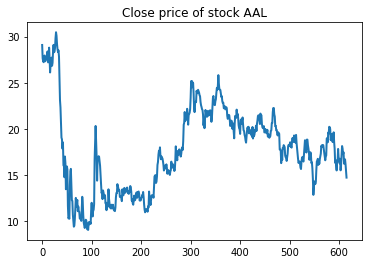

In [37]:
#Plot the close price of stock AAL
plt.plot(aal_close, linewidth = 2)
plt.title('Close price of stock AAL')

Text(0.5, 1.0, 'Difference of the close price of stock AAL')

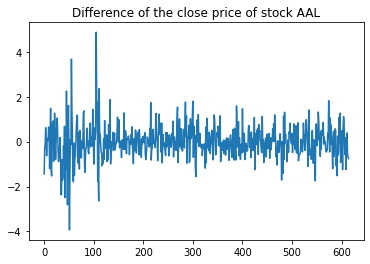

In [38]:
#Plot the difference of the close price of stock AAL
plt.plot(aal_close_diff, linewidth = 1.5)
plt.title('Difference of the close price of stock AAL')

In [39]:
#ADF of price
result_aal = adfuller(aal_close)
print('ADF Statistic: %f' % result_aal[0])
print('p-value: %f' % result_aal[1])
for key, value in result_aal[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.552431
p-value: 0.103233
	1%: -3.441
	5%: -2.866
	10%: -2.569


ADF Statistic: -2.552431 > critical value 1%: -3.441, 5%: -2.866, 10%: -2.569, so fail to reject the null hypothesis.

p-value = 0.103233 > 0.05(5% significance level or 95% confidence interval), which means that the data has a unit root, so we fail to reject the null hypothesis.
It is non-stationary, and does have time-dependent structure.

In [40]:
#ADF of price difference
result_aal_diff = adfuller(aal_close_diff)
print('ADF Statistic: %f' % result_aal_diff[0])
print('p-value: %f' % result_aal_diff[1])
for key, value in result_aal_diff[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -15.501151
p-value: 0.000000
	1%: -3.441
	5%: -2.866
	10%: -2.569


ADF Statistic:-15.501151 < critical value 1%: -3.441, 5%: -2.866, 10%: -2.569, so we reject the null hypothesis.

p-value = 0.000000 < 0.05(5% significance level or 95% confidence interval), which means that the data does not have a unit root, so we reject the null hypothesis.
It is stationary.

In [41]:
#ADF of log price
result_aal_log = adfuller(aal_close_log)
print('ADF Statistic: %f' % result_aal_log[0])
print('p-value: %f' % result_aal_log[1])
for key, value in result_aal_log[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.808060
p-value: 0.057132
	1%: -3.441
	5%: -2.866
	10%: -2.569


ADF Statistic: -2.808060 > critical value 1%: -3.441, 5%: -2.866, 10%: -2.569, so fail to reject the null hypothesis.

p-value = 0.057132 > 0.05(5% significance level or 95% confidence interval), which means that the data has a unit root, so we fail to reject the null hypothesis.
It is non-stationary, and does have time-dependent structure.

In [42]:
#ADF of log price difference
result_aal_log_diff = adfuller(aal_close_log_diff)
print('ADF Statistic: %f' % result_aal_log_diff[0])
print('p-value: %f' % result_aal_log_diff[1])
for key, value in result_aal_log_diff[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.327457
p-value: 0.000000
	1%: -3.441
	5%: -2.866
	10%: -2.569


ADF Statistic:-7.327457 < critical value 1%: -3.441, 5%: -2.866, 10%: -2.569, so we reject the null hypothesis.

p-value = 0.000000 < 0.05(5% significance level or 95% confidence interval), which means that the data does not have a unit root, so we reject the null hypothesis. It is stationary.

In [43]:
def plot_diagnosticsTight2(data, rtn, title1 = 'AAL'):

    fig, axes = plt.subplots(1,2,figsize=(15,5))
    axes[0].set_ylabel('ACF', fontsize=15)
    axes[0].set_xlabel('Lag', fontsize=15)
    fig = plot_acf(data,lags=25,zero=True, ax = axes[0], title= 'ACF '+ title1, use_vlines = True)
    axes[1].set_ylabel('ACF', fontsize=15)
    axes[1].set_xlabel('Lag', fontsize=15)
    fig = plot_acf(rtn,lags=25,zero=True, ax = axes[1], title= 'ACF Returns '+ title1, use_vlines = True)
    plt.tight_layout()
    plt.savefig("ACF2.png", dpi = 300)

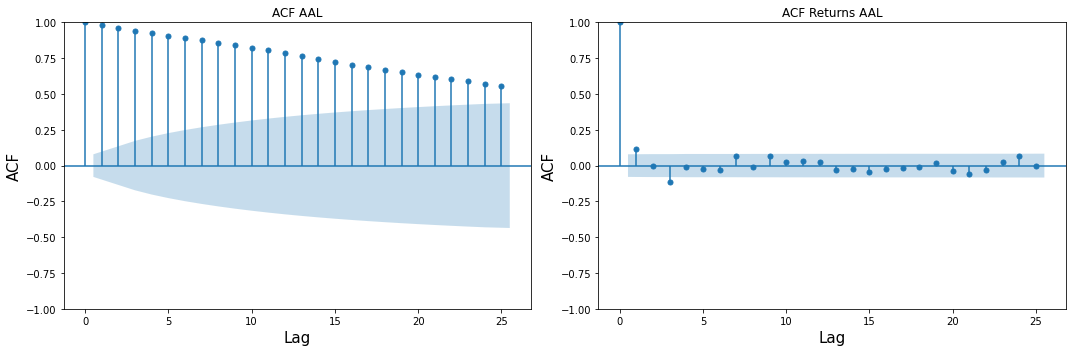

In [44]:
plot_diagnosticsTight2(aal_close,aal_close_diff)

In [45]:
def plot_diagnosticsTight2(data, rtn, title1 = 'AAL'):

    fig, axes = plt.subplots(1,2,figsize=(15,5))
    axes[0].set_ylabel('ACF', fontsize=15)
    axes[0].set_xlabel('Lag', fontsize=15)
    fig = plot_acf(data,lags=25,zero=True, ax = axes[0], title= 'ACF log '+ title1, use_vlines = True)
    axes[1].set_ylabel('ACF', fontsize=15)
    axes[1].set_xlabel('Lag', fontsize=15)
    fig = plot_acf(rtn,lags=25,zero=True, ax = axes[1], title= 'ACF log Returns '+ title1, use_vlines = True)
    plt.tight_layout()
    plt.savefig("ACF2.png", dpi = 300)

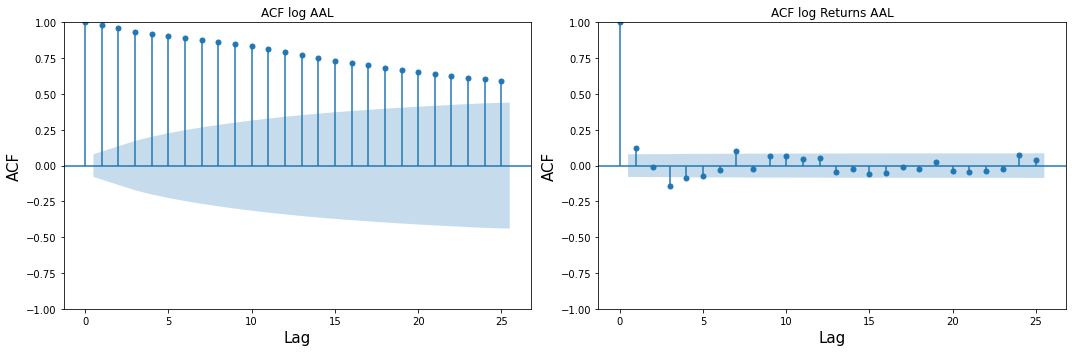

In [46]:
plot_diagnosticsTight2(aal_close_log,aal_close_log_diff)

In [47]:
# Get the number of rows to train the model on
training_data_len_aal = int(np.ceil( len(dataset_aal) * .95 ))
training_data_len_aal

586

In [48]:
#training set and testing set
train_diff_aal = aal_close_diff[0:training_data_len_aal]
test_diff_aal = aal_close_diff[training_data_len_aal:]

# Fit a model with price difference (AAL)

In [49]:
from pmdarima.arima.utils import ndiffs

#Find d-value of ARIMA(p,d,q)
d_val = ndiffs(train_diff_aal, test='adf')
print('ARIMA d-value:', d_val)

ARIMA d-value: 0


In [50]:
import pmdarima as pm
model_aal = pm.auto_arima(train_diff_aal,
                      d = d_val,
                      start_p = 0,
                      max_p = 10,
                      start_q = 0,
                      max_q = 10,   
                      stepwise=False,
                      max_order=30,
                      supress_warnings=True,
                      seasonal=False,
                      trace=True)

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1333.614, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1326.411, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1328.072, Time=0.04 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1321.935, Time=0.04 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=1323.836, Time=0.05 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,0,5)(0,0,0)[0]             : AIC=1325.494, Time=0.07 sec
 ARIMA(0,0,6)(0,0,0)[0]             : AIC=1327.290, Time=0.08 sec
 ARIMA(0,0,7)(0,0,0)[0]             : AIC=1325.719, Time=0.09 sec
 ARIMA(0,0,8)(0,0,0)[0]             : AIC=1327.266, Time=0.12 sec
 ARIMA(0,0,9)(0,0,0)[0]             : AIC=1326.432, Time=0.17 sec
 ARIMA(0,0,10)(0,0,0)[0]             : AIC=1328.198, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1326.388, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1328.297, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1327.490, Time=0.09 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered

 ARIMA(1,0,3)(0,0,0)[0]             : AIC=1323.791, Time=0.08 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=1325.387, Time=0.20 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,5)(0,0,0)[0]             : AIC=1327.464, Time=0.14 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,6)(0,0,0)[0]             : AIC=1326.568, Time=0.21 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,7)(0,0,0)[0]             : AIC=1326.358, Time=0.25 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,8)(0,0,0)[0]             : AIC=1328.347, Time=0.33 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,9)(0,0,0)[0]             : AIC=1327.717, Time=0.32 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,0,10)(0,0,0)[0]             : AIC=1329.710, Time=0.35 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1328.133, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1327.791, Time=0.09 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1323.060, Time=0.17 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=1325.744, Time=0.13 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=1319.904, Time=0.30 sec
 ARIMA(2,0,5)(0,0,0)[0]             : AIC=1328.975, Time=0.28 sec
 ARIMA(2,0,6)(0,0,0)[0]             : AIC=1321.513, Time=0.51 sec
 ARIMA(2,0,7)(0,0,0)[0]             : AIC=1327.508, Time=0.32 sec
 ARIMA(2,0,8)(0,0,0)[0]             : AIC=1329.403, Time=0.32 sec
 ARIMA(2,0,9)(0,0,0)[0]             : AIC=1329.694, Time=0.55 sec
 ARIMA(2,0,10)(0,0,0)[0]             : AIC=1331.680, Time=0.80 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=1322.822, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=1324.589, Time=0.06 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,0,2)(0,0,0)[0]             : AIC=1326.588, Time=0.12 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=1326.648, Time=0.23 sec
 ARIMA(3,0,4)(0,0,0)[0]             : AIC=1320.144, Time=0.52 sec
 ARIMA(3,0,5)(0,0,0)[0]             : AIC=inf, Time=0.63 sec
 ARIMA(3,0,6)(0,0,0)[0]             : AIC=1323.903, Time=0.47 sec
 ARIMA(3,0,7)(0,0,0)[0]             : AIC=1325.322, Time=0.69 sec
 ARIMA(3,0,8)(0,0,0)[0]             : AIC=1326.085, Time=0.80 sec
 ARIMA(3,0,9)(0,0,0)[0]             : AIC=1327.955, Time=0.93 sec
 ARIMA(3,0,10)(0,0,0)[0]             : AIC=1329.780, Time=1.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=1324.640, Time=0.04 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(4,0,1)(0,0,0)[0]             : AIC=1326.589, Time=0.17 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=1328.542, Time=0.22 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=1324.175, Time=0.36 sec
 ARIMA(4,0,4)(0,0,0)[0]             : AIC=1321.325, Time=0.48 sec
 ARIMA(4,0,5)(0,0,0)[0]             : AIC=1316.368, Time=0.59 sec
 ARIMA(4,0,6)(0,0,0)[0]             : AIC=1321.815, Time=0.80 sec
 ARIMA(4,0,7)(0,0,0)[0]             : AIC=1320.862, Time=0.81 sec
 ARIMA(4,0,8)(0,0,0)[0]             : AIC=1323.595, Time=0.90 sec
 ARIMA(4,0,9)(0,0,0)[0]             : AIC=1325.680, Time=0.95 sec
 ARIMA(4,0,10)(0,0,0)[0]             : AIC=inf, Time=1.46 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=1326.362, Time=0.05 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=1328.309, Time=0.14 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(5,0,2)(0,0,0)[0]             : AIC=1323.099, Time=0.47 sec
 ARIMA(5,0,3)(0,0,0)[0]             : AIC=1321.605, Time=0.51 sec
 ARIMA(5,0,4)(0,0,0)[0]             : AIC=1321.815, Time=0.61 sec
 ARIMA(5,0,5)(0,0,0)[0]             : AIC=1319.119, Time=0.64 sec
 ARIMA(5,0,6)(0,0,0)[0]             : AIC=1323.028, Time=0.84 sec
 ARIMA(5,0,7)(0,0,0)[0]             : AIC=inf, Time=1.02 sec
 ARIMA(5,0,8)(0,0,0)[0]             : AIC=1328.704, Time=1.11 sec
 ARIMA(5,0,9)(0,0,0)[0]             : AIC=inf, Time=1.23 sec
 ARIMA(5,0,10)(0,0,0)[0]             : AIC=inf, Time=2.16 sec
 ARIMA(6,0,0)(0,0,0)[0]             : AIC=1328.008, Time=0.06 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(6,0,1)(0,0,0)[0]             : AIC=1327.459, Time=0.23 sec
 ARIMA(6,0,2)(0,0,0)[0]             : AIC=1321.345, Time=0.61 sec
 ARIMA(6,0,3)(0,0,0)[0]             : AIC=1323.357, Time=0.63 sec
 ARIMA(6,0,4)(0,0,0)[0]             : AIC=1323.722, Time=0.65 sec
 ARIMA(6,0,5)(0,0,0)[0]             : AIC=inf, Time=0.77 sec
 ARIMA(6,0,6)(0,0,0)[0]             : AIC=1327.915, Time=0.79 sec
 ARIMA(6,0,7)(0,0,0)[0]             : AIC=1324.111, Time=1.05 sec
 ARIMA(6,0,8)(0,0,0)[0]             : AIC=1325.946, Time=1.17 sec
 ARIMA(6,0,9)(0,0,0)[0]             : AIC=1326.706, Time=1.23 sec
 ARIMA(6,0,10)(0,0,0)[0]             : AIC=1330.220, Time=1.52 sec
 ARIMA(7,0,0)(0,0,0)[0]             : AIC=1327.178, Time=0.08 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(7,0,1)(0,0,0)[0]             : AIC=1327.723, Time=0.19 sec
 ARIMA(7,0,2)(0,0,0)[0]             : AIC=1329.439, Time=0.34 sec
 ARIMA(7,0,3)(0,0,0)[0]             : AIC=1325.285, Time=0.65 sec
 ARIMA(7,0,4)(0,0,0)[0]             : AIC=1325.950, Time=0.70 sec
 ARIMA(7,0,5)(0,0,0)[0]             : AIC=1323.411, Time=0.78 sec
 ARIMA(7,0,6)(0,0,0)[0]             : AIC=inf, Time=0.96 sec
 ARIMA(7,0,7)(0,0,0)[0]             : AIC=inf, Time=1.20 sec
 ARIMA(7,0,8)(0,0,0)[0]             : AIC=inf, Time=1.63 sec
 ARIMA(7,0,9)(0,0,0)[0]             : AIC=inf, Time=1.65 sec
 ARIMA(7,0,10)(0,0,0)[0]             : AIC=inf, Time=1.75 sec
 ARIMA(8,0,0)(0,0,0)[0]             : AIC=1328.250, Time=0.08 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(8,0,1)(0,0,0)[0]             : AIC=1329.539, Time=0.22 sec
 ARIMA(8,0,2)(0,0,0)[0]             : AIC=1325.165, Time=0.76 sec
 ARIMA(8,0,3)(0,0,0)[0]             : AIC=1327.067, Time=0.80 sec
 ARIMA(8,0,4)(0,0,0)[0]             : AIC=1324.105, Time=0.90 sec
 ARIMA(8,0,5)(0,0,0)[0]             : AIC=1324.356, Time=0.98 sec
 ARIMA(8,0,6)(0,0,0)[0]             : AIC=1326.853, Time=1.28 sec
 ARIMA(8,0,7)(0,0,0)[0]             : AIC=inf, Time=1.51 sec
 ARIMA(8,0,8)(0,0,0)[0]             : AIC=inf, Time=1.33 sec
 ARIMA(8,0,9)(0,0,0)[0]             : AIC=inf, Time=1.89 sec
 ARIMA(8,0,10)(0,0,0)[0]             : AIC=inf, Time=2.03 sec
 ARIMA(9,0,0)(0,0,0)[0]             : AIC=1327.974, Time=0.12 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(9,0,1)(0,0,0)[0]             : AIC=1328.817, Time=0.35 sec
 ARIMA(9,0,2)(0,0,0)[0]             : AIC=1330.748, Time=0.50 sec
 ARIMA(9,0,3)(0,0,0)[0]             : AIC=1329.091, Time=1.05 sec
 ARIMA(9,0,4)(0,0,0)[0]             : AIC=1326.612, Time=0.99 sec
 ARIMA(9,0,5)(0,0,0)[0]             : AIC=inf, Time=1.17 sec
 ARIMA(9,0,6)(0,0,0)[0]             : AIC=1328.937, Time=1.28 sec
 ARIMA(9,0,7)(0,0,0)[0]             : AIC=inf, Time=1.67 sec
 ARIMA(9,0,8)(0,0,0)[0]             : AIC=inf, Time=1.98 sec
 ARIMA(9,0,9)(0,0,0)[0]             : AIC=inf, Time=1.81 sec
 ARIMA(9,0,10)(0,0,0)[0]             : AIC=inf, Time=2.15 sec
 ARIMA(10,0,0)(0,0,0)[0]             : AIC=1329.156, Time=0.12 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(10,0,1)(0,0,0)[0]             : AIC=1330.782, Time=0.41 sec
 ARIMA(10,0,2)(0,0,0)[0]             : AIC=1332.365, Time=0.55 sec
 ARIMA(10,0,3)(0,0,0)[0]             : AIC=1330.263, Time=1.04 sec
 ARIMA(10,0,4)(0,0,0)[0]             : AIC=1328.091, Time=1.34 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(10,0,5)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/pmdarima/arima/arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/pmdarima/arima/arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/pmdarima/arima/arima.py", line 515, in _fit_wrapper
    **fit_args,
  File "/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace

 ARIMA(10,0,5)(0,0,0)[0]             : AIC=inf, Time=nan sec
 ARIMA(10,0,6)(0,0,0)[0]             : AIC=1330.879, Time=1.32 sec
 ARIMA(10,0,7)(0,0,0)[0]             : AIC=inf, Time=1.54 sec
 ARIMA(10,0,8)(0,0,0)[0]             : AIC=inf, Time=1.75 sec
 ARIMA(10,0,9)(0,0,0)[0]             : AIC=inf, Time=1.95 sec
 ARIMA(10,0,10)(0,0,0)[0]             : AIC=inf, Time=2.14 sec

Best model:  ARIMA(4,0,5)(0,0,0)[0]          
Total fit time: 84.674 seconds


In [51]:
model_aal.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  586
Model:               SARIMAX(4, 0, 5)   Log Likelihood                -648.184
Date:                Mon, 12 Dec 2022   AIC                           1316.368
Time:                        00:00:58   BIC                           1360.101
Sample:                             0   HQIC                          1333.411
                                - 586                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1985      0.056      3.574      0.000       0.090       0.307
ar.L2          1.0412      0.062     16.685      0.000       0.919       1.164
ar.L3          0.1631      0.052      3.149      0.002       0.062       0.265
ar.L4         -0.8355      0.056    -15.039      0.000      -0.944      -0.727
ma.L1         -0.0607      0.066     -0.923      0.356      -0.190       0.068
ma.L2         -1.0703      0.052    -20.396      0.000      -1.173      -0.967
ma.L3         -0.4109      0.056     -7.375      0.000      -0.520      -0.302
ma.L4          0.8553      0.048     17.687      0.000       0.761       0.950
ma.L5          0.2008      0.039      5.146      0.000       0.124       0.277
sigma2         0.5353      0.021     25.075      0.000       0.493       0.577
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               535.89
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.37   Skew:                             0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [52]:
model_aal_arima = ARIMA(train_diff_aal, order=(4,0,5))
ARMA_res_aal = model_aal_arima.fit()
print(ARMA_res_aal.summary());

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  586
Model:                 ARIMA(4, 0, 5)   Log Likelihood                -647.952
Date:                Mon, 12 Dec 2022   AIC                           1317.905
Time:                        00:00:59   BIC                           1366.011
Sample:                             0   HQIC                          1336.651
                                - 586                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0133      0.037     -0.360      0.719      -0.086       0.059
ar.L1          0.2143      0.051      4.167      0.000       0.113       0.315
ar.L2          1.0273      0.059     17.281      0.0

/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [53]:
pred_aal = ARMA_res_aal.predict(start = 586, end = 615)
pred_aal

array([ 0.06405277,  0.03921556,  0.16989427, -0.10840176, -0.0712147 ,
       -0.13584352, -0.27016984, -0.12406807, -0.27337682, -0.12412368,
       -0.10677124, -0.09897663,  0.07246494, -0.00570309,  0.14038395,
        0.11463849,  0.10094516,  0.16293472,  0.03441304,  0.08989612,
       -0.00790508, -0.04652814, -0.03718282, -0.13868741, -0.07503911,
       -0.13146285, -0.10371403, -0.05901527, -0.08445129,  0.00845157])

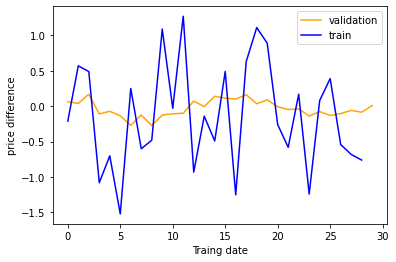

In [54]:
plt.grid()
plt.plot(pred_aal, color = 'orange', linewidth=1.5)
plt.plot(aal_close_diff[586:], color ='b',linewidth=1.5)
plt.xlabel('Traing date')
plt.ylabel('price difference')
plt.legend(['validation','train'])
plt.grid()
plt.show()

In [55]:
def plot_diagnosticsTight3(data):

    fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,6))
    
    ax1.hist(data, bins =40,color='m', density = True)  
    mu = data.mean()
    sigma = data.std()
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 2419)
    ax1.plot(x, stats.norm.pdf(x, mu, sigma), linewidth= 5)
    ax1.grid()
    ax1.set_title("Hist Resid")
    
    ax2.plot(data)
    ax2.grid()
    ax2.set_title("Resid")
    
    fig = plot_acf(data,lags=40,zero=False, ax = ax3,use_vlines = True)
    ax3.grid()
    
   
    
    
    fig = sm.qqplot(data, line='q', ax = ax4)
    ax4.grid()
    
   
    plt.tight_layout()


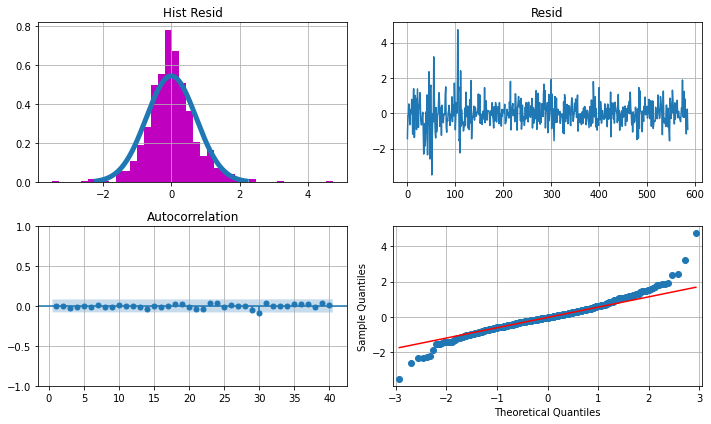

In [56]:
resid_aal = ARMA_res_aal.resid
plot_diagnosticsTight3(resid_aal)

In [57]:
pred_aal_full = ARMA_res_aal.predict(start = 0, end = 615)
pred_aal_full

array([-1.33119068e-02, -1.93809113e-01, -3.39019671e-02,  8.90611516e-02,
        5.52503982e-02,  1.82842847e-02, -1.25192924e-01, -7.01601131e-02,
        7.01641028e-02, -1.37631504e-01,  7.07222068e-02, -2.31732909e-02,
       -3.18470971e-01,  8.97609505e-02,  2.08224627e-01, -2.06828316e-01,
       -2.26862888e-01,  2.62511957e-01,  7.89139179e-02,  4.35861224e-02,
        2.64666469e-02, -1.11736471e-01,  2.73860759e-01, -6.26809524e-04,
       -3.69374700e-01,  1.19377206e-01, -1.18550943e-01,  1.34520411e-01,
        6.15713656e-02, -2.33562659e-01,  1.08842137e-02, -7.94438893e-02,
        1.19721665e-01,  1.93630292e-01, -6.57767903e-02, -1.44350513e-01,
       -2.32793865e-01,  1.39555188e-01, -1.11653648e-01, -2.76728135e-01,
        1.11433468e-01, -3.64137452e-01, -1.42246241e-01, -5.07218036e-01,
       -5.38979488e-01, -1.02064901e-01, -1.71700635e-01, -2.28929003e-01,
       -6.04773548e-01,  1.99926843e-02,  6.75856930e-01, -4.43777908e-01,
       -1.44641482e-01,  

In [58]:
# return difference with true close price
pred_aal_arima = []
pred_aal_arima.append(aal_close[0])
for i in range(0,615):
        pred_aal_arima.append(pred_aal_full[i]+aal_close[i])

In [59]:
# Get the root mean squared error (RMSE) of full aal
rmse_aal_arima = np.sqrt(np.mean(((pred_aal_arima - aal_close) ** 2)))
rmse_aal_arima

0.7315170958682153

In [60]:
# Get the root mean squared error (RMSE) of training data
rmse_train_aal_arima = np.sqrt(np.mean(((pred_aal_arima[0:training_data_len_aal] - aal_close[0:training_data_len_aal]) ** 2)))
rmse_train_aal_arima

0.7306875302442136

In [61]:
# Get the root mean squared error (RMSE) of testing data
rmse_test_aal_arima = np.sqrt(np.mean(((pred_aal_arima[training_data_len_aal:] - aal_close[training_data_len_aal:]) ** 2)))
rmse_test_aal_arima

0.7475366821895406

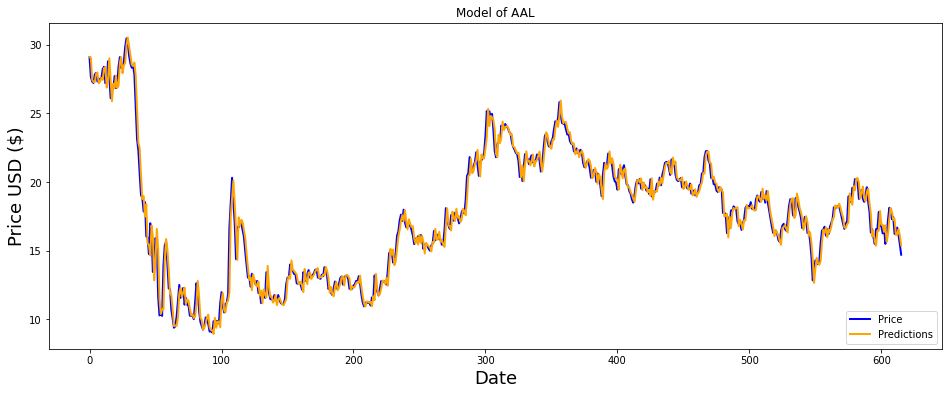

In [62]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model of AAL')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price USD ($)', fontsize=18)
plt.plot(aal_close, label='Price', color = 'b', linewidth =2.0)
plt.plot(pred_aal_arima, label='Prediction', color='orange', linewidth =2.0)
plt.legend(['Price', 'Predictions'], loc='lower right')
plt.savefig('arima_aal.png', dpi = 500)
plt.show()

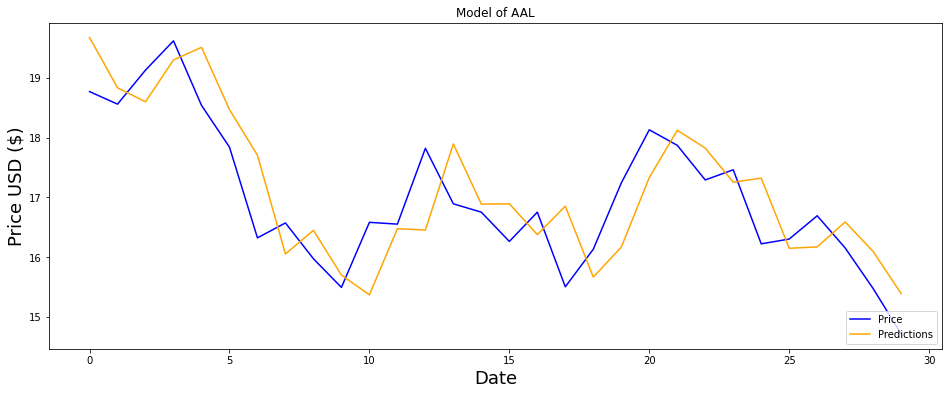

In [63]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model of AAL')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price USD ($)', fontsize=18)
plt.plot(aal_close[training_data_len_aal:], label='Price', color = 'b', linewidth =1.5)
plt.plot(pred_aal_arima[training_data_len_aal:], label='Prediction', color='orange', linewidth =1.5)
plt.legend(['Price', 'Predictions'], loc='lower right')
plt.savefig('arima_aal_train.png', dpi = 500)
plt.show()

/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


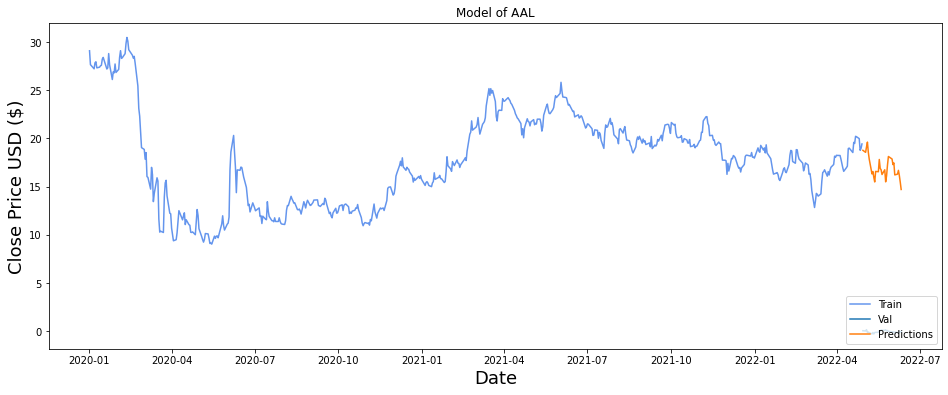

In [64]:
train_aal_arima = df_aal[:training_data_len_aal]
valid_aal_arima = df_aal[training_data_len_aal:]
valid_aal_arima['Predictions'] = pred_aal
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model of AAL')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train_aal_arima['Close'], linewidth =1.5,color ='cornflowerblue')
plt.plot(valid_aal_arima[['Predictions','Close']], linewidth =1.5)
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.savefig('arima_aal_full.png', dpi = 500)
plt.show()

# Fit model with log price difference (AAL)

In [65]:
#training set and testing set
train_log_diff_aal = aal_close_log_diff[0:training_data_len_aal]
test_log_diff_aal = aal_close_log_diff[training_data_len_aal:]

In [66]:
from pmdarima.arima.utils import ndiffs

#Find d-value of ARIMA(p,d,q)
d_val_log = ndiffs(train_log_diff_aal, test='adf')
print('ARIMA d-value:', d_val_log)

ARIMA d-value: 0


In [67]:
import pmdarima as pm
from pmdarima.arima import auto_arima

In [68]:
train_log_diff_aal = np.asarray(train_log_diff_aal)

In [69]:
model_aal_log = pm.auto_arima(train_log_diff_aal,
                      d = d_val_log,
                      start_p = 0,
                      max_p = 10,
                      start_q = 0,
                      max_q = 10,   
                      stepwise=False,
                      max_order=30,
                      supress_warnings=True,
                      seasonal=False,
                      trace=True)

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-1891.466, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-1899.651, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-1897.923, Time=0.06 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-1906.264, Time=0.10 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,0,4)(0,0,0)[0]             : AIC=-1905.455, Time=0.12 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=-1905.669, Time=0.17 sec
 ARIMA(0,0,6)(0,0,0)[0]             : AIC=-1904.065, Time=0.26 sec
 ARIMA(0,0,7)(0,0,0)[0]             : AIC=-1913.358, Time=0.35 sec
 ARIMA(0,0,8)(0,0,0)[0]             : AIC=-1911.660, Time=0.31 sec
 ARIMA(0,0,9)(0,0,0)[0]             : AIC=-1913.193, Time=0.35 sec
 ARIMA(0,0,10)(0,0,0)[0]             : AIC=-1912.622, Time=0.47 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1899.539, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1897.730, Time=0.08 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered

 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-1899.794, Time=0.16 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-1906.362, Time=0.15 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,4)(0,0,0)[0]             : AIC=-1904.388, Time=0.37 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,5)(0,0,0)[0]             : AIC=-1903.745, Time=0.23 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,6)(0,0,0)[0]             : AIC=-1906.996, Time=0.43 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,7)(0,0,0)[0]             : AIC=-1912.208, Time=0.53 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,8)(0,0,0)[0]             : AIC=-1909.441, Time=0.64 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,9)(0,0,0)[0]             : AIC=-1913.069, Time=0.72 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,0,10)(0,0,0)[0]             : AIC=-1911.374, Time=0.80 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-1898.123, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-1903.505, Time=0.14 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-1908.375, Time=0.21 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-1906.225, Time=0.30 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=-1902.386, Time=0.26 sec
 ARIMA(2,0,5)(0,0,0)[0]             : AIC=-1906.161, Time=0.43 sec
 ARIMA(2,0,6)(0,0,0)[0]             : AIC=-1905.271, Time=0.47 sec
 ARIMA(2,0,7)(0,0,0)[0]             : AIC=-1912.653, Time=0.52 sec
 ARIMA(2,0,8)(0,0,0)[0]             : AIC=-1910.847, Time=0.68 sec
 ARIMA(2,0,9)(0,0,0)[0]             : AIC=-1910.628, Time=0.75 sec
 ARIMA(2,0,10)(0,0,0)[0]             : AIC=-1909.284, Time=0.92 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-1907.357, Time=0.03 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-1908.223, Time=0.20 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-1906.329, Time=0.29 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-1904.774, Time=0.35 sec
 ARIMA(3,0,4)(0,0,0)[0]             : AIC=inf, Time=0.47 sec
 ARIMA(3,0,5)(0,0,0)[0]             : AIC=-1900.613, Time=0.47 sec
 ARIMA(3,0,6)(0,0,0)[0]             : AIC=-1904.663, Time=0.60 sec
 ARIMA(3,0,7)(0,0,0)[0]             : AIC=-1911.215, Time=0.69 sec
 ARIMA(3,0,8)(0,0,0)[0]             : AIC=-1909.065, Time=0.72 sec
 ARIMA(3,0,9)(0,0,0)[0]             : AIC=-1908.234, Time=0.81 sec
 ARIMA(3,0,10)(0,0,0)[0]             : AIC=-1908.550, Time=0.97 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=-1907.145, Time=0.05 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(4,0,1)(0,0,0)[0]             : AIC=-1906.240, Time=0.31 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=-1904.453, Time=0.35 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=-1902.374, Time=0.48 sec
 ARIMA(4,0,4)(0,0,0)[0]             : AIC=-1909.745, Time=0.52 sec
 ARIMA(4,0,5)(0,0,0)[0]             : AIC=-1920.872, Time=0.59 sec
 ARIMA(4,0,6)(0,0,0)[0]             : AIC=-1914.534, Time=0.64 sec
 ARIMA(4,0,7)(0,0,0)[0]             : AIC=-1916.364, Time=0.68 sec
 ARIMA(4,0,8)(0,0,0)[0]             : AIC=-1913.496, Time=0.75 sec
 ARIMA(4,0,9)(0,0,0)[0]             : AIC=-1914.895, Time=0.92 sec
 ARIMA(4,0,10)(0,0,0)[0]             : AIC=-1915.691, Time=1.03 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=-1906.874, Time=0.06 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(5,0,1)(0,0,0)[0]             : AIC=-1904.979, Time=0.36 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(5,0,2)(0,0,0)[0]             : AIC=-1902.459, Time=0.39 sec
 ARIMA(5,0,3)(0,0,0)[0]             : AIC=-1903.758, Time=0.44 sec
 ARIMA(5,0,4)(0,0,0)[0]             : AIC=-1902.592, Time=0.48 sec
 ARIMA(5,0,5)(0,0,0)[0]             : AIC=-1919.370, Time=0.63 sec
 ARIMA(5,0,6)(0,0,0)[0]             : AIC=-1912.043, Time=0.66 sec
 ARIMA(5,0,7)(0,0,0)[0]             : AIC=-1915.953, Time=0.78 sec
 ARIMA(5,0,8)(0,0,0)[0]             : AIC=-1914.072, Time=0.89 sec
 ARIMA(5,0,9)(0,0,0)[0]             : AIC=-1909.477, Time=0.96 sec
 ARIMA(5,0,10)(0,0,0)[0]             : AIC=-1911.818, Time=1.19 sec
 ARIMA(6,0,0)(0,0,0)[0]             : AIC=-1905.277, Time=0.20 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(6,0,1)(0,0,0)[0]             : AIC=-1906.984, Time=0.41 sec
 ARIMA(6,0,2)(0,0,0)[0]             : AIC=-1912.416, Time=0.46 sec
 ARIMA(6,0,3)(0,0,0)[0]             : AIC=-1904.732, Time=0.53 sec
 ARIMA(6,0,4)(0,0,0)[0]             : AIC=-1905.636, Time=0.58 sec
 ARIMA(6,0,5)(0,0,0)[0]             : AIC=-1908.828, Time=0.63 sec
 ARIMA(6,0,6)(0,0,0)[0]             : AIC=-1904.302, Time=0.96 sec
 ARIMA(6,0,7)(0,0,0)[0]             : AIC=-1920.308, Time=0.89 sec
 ARIMA(6,0,8)(0,0,0)[0]             : AIC=-1918.885, Time=1.03 sec
 ARIMA(6,0,9)(0,0,0)[0]             : AIC=-1916.670, Time=1.04 sec
 ARIMA(6,0,10)(0,0,0)[0]             : AIC=-1914.704, Time=1.16 sec
 ARIMA(7,0,0)(0,0,0)[0]             : AIC=-1907.604, Time=0.10 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(7,0,1)(0,0,0)[0]             : AIC=-1908.364, Time=0.41 sec
 ARIMA(7,0,2)(0,0,0)[0]             : AIC=-1905.552, Time=0.56 sec
 ARIMA(7,0,3)(0,0,0)[0]             : AIC=-1911.552, Time=0.62 sec
 ARIMA(7,0,4)(0,0,0)[0]             : AIC=-1909.969, Time=0.66 sec
 ARIMA(7,0,5)(0,0,0)[0]             : AIC=-1907.735, Time=0.70 sec
 ARIMA(7,0,6)(0,0,0)[0]             : AIC=inf, Time=1.03 sec
 ARIMA(7,0,7)(0,0,0)[0]             : AIC=-1919.384, Time=1.02 sec
 ARIMA(7,0,8)(0,0,0)[0]             : AIC=-1916.580, Time=1.04 sec
 ARIMA(7,0,9)(0,0,0)[0]             : AIC=-1915.746, Time=1.15 sec
 ARIMA(7,0,10)(0,0,0)[0]             : AIC=-1912.698, Time=1.27 sec
 ARIMA(8,0,0)(0,0,0)[0]             : AIC=-1908.852, Time=0.10 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(8,0,1)(0,0,0)[0]             : AIC=-1907.521, Time=0.47 sec
 ARIMA(8,0,2)(0,0,0)[0]             : AIC=-1906.869, Time=0.62 sec
 ARIMA(8,0,3)(0,0,0)[0]             : AIC=-1910.564, Time=0.73 sec
 ARIMA(8,0,4)(0,0,0)[0]             : AIC=-1905.956, Time=0.81 sec
 ARIMA(8,0,5)(0,0,0)[0]             : AIC=-1916.050, Time=0.92 sec
 ARIMA(8,0,6)(0,0,0)[0]             : AIC=-1909.176, Time=0.91 sec
 ARIMA(8,0,7)(0,0,0)[0]             : AIC=-1906.333, Time=1.38 sec
 ARIMA(8,0,8)(0,0,0)[0]             : AIC=-1913.493, Time=1.20 sec
 ARIMA(8,0,9)(0,0,0)[0]             : AIC=-1910.625, Time=1.25 sec
 ARIMA(8,0,10)(0,0,0)[0]             : AIC=-1910.847, Time=1.63 sec
 ARIMA(9,0,0)(0,0,0)[0]             : AIC=-1909.003, Time=0.11 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(9,0,1)(0,0,0)[0]             : AIC=-1911.125, Time=0.68 sec
 ARIMA(9,0,2)(0,0,0)[0]             : AIC=-1906.609, Time=0.70 sec
 ARIMA(9,0,3)(0,0,0)[0]             : AIC=-1905.401, Time=0.78 sec
 ARIMA(9,0,4)(0,0,0)[0]             : AIC=-1903.614, Time=0.85 sec
 ARIMA(9,0,5)(0,0,0)[0]             : AIC=-1902.326, Time=0.93 sec
 ARIMA(9,0,6)(0,0,0)[0]             : AIC=inf, Time=1.52 sec
 ARIMA(9,0,7)(0,0,0)[0]             : AIC=inf, Time=1.78 sec
 ARIMA(9,0,8)(0,0,0)[0]             : AIC=-1908.281, Time=1.13 sec
 ARIMA(9,0,9)(0,0,0)[0]             : AIC=-1913.553, Time=1.39 sec
 ARIMA(9,0,10)(0,0,0)[0]             : AIC=-1909.096, Time=1.45 sec
 ARIMA(10,0,0)(0,0,0)[0]             : AIC=-1911.072, Time=0.22 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(10,0,1)(0,0,0)[0]             : AIC=-1910.055, Time=0.73 sec
 ARIMA(10,0,2)(0,0,0)[0]             : AIC=-1909.080, Time=0.80 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(10,0,3)(0,0,0)[0]             : AIC=-1906.981, Time=0.84 sec
 ARIMA(10,0,4)(0,0,0)[0]             : AIC=-1912.358, Time=0.98 sec
 ARIMA(10,0,5)(0,0,0)[0]             : AIC=-1908.394, Time=1.05 sec
 ARIMA(10,0,6)(0,0,0)[0]             : AIC=-1905.269, Time=1.45 sec
 ARIMA(10,0,7)(0,0,0)[0]             : AIC=-1911.477, Time=1.28 sec
 ARIMA(10,0,8)(0,0,0)[0]             : AIC=-1909.619, Time=1.31 sec
 ARIMA(10,0,9)(0,0,0)[0]             : AIC=-1910.445, Time=1.98 sec
 ARIMA(10,0,10)(0,0,0)[0]             : AIC=-1907.123, Time=1.60 sec

Best model:  ARIMA(4,0,5)(0,0,0)[0]          
Total fit time: 79.954 seconds


In [70]:
model_aal_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  586
Model:               SARIMAX(4, 0, 5)   Log Likelihood                 970.436
Date:                Mon, 12 Dec 2022   AIC                          -1920.872
Time:                        00:02:26   BIC                          -1877.139
Sample:                             0   HQIC                         -1903.830
                                - 586                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0045      0.074      0.061      0.951      -0.140       0.149
ar.L2          0.9279      0.069     13.428      0.000       0.792       1.063
ar.L3          0.2260      0.060      3.764      0.000       0.108       0.344
ar.L4         -0.7102      0.061    -11.698      0.000      -0.829      -0.591
ma.L1          0.1217      0.081      1.496      0.135      -0.038       0.281
ma.L2         -0.9977      0.066    -15.122      0.000      -1.127      -0.868
ma.L3         -0.5110      0.060     -8.472      0.000      -0.629      -0.393
ma.L4          0.7196      0.063     11.346      0.000       0.595       0.844
ma.L5          0.2510      0.033      7.639      0.000       0.187       0.315
sigma2         0.0021   7.92e-05     27.012      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              1561.56
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.26   Skew:                             0.85
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [71]:
model_aal_log_arima = ARIMA(train_log_diff_aal, order=(4,0,5))
ARMA_res_aal_log = model_aal_log_arima.fit()
# print(ARMA_res_aal_log.summary());

/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [72]:
pred_aal_log = ARMA_res_aal_log.predict(start = 586, end = 615)
pred_aal_log

array([ 0.00623784,  0.0024709 ,  0.01397692, -0.00441606, -0.00302552,
       -0.00319321, -0.01353943, -0.0011    , -0.01063065, -0.0022641 ,
       -0.00066469, -0.00394108,  0.00550627, -0.00246212,  0.00364736,
        0.00114807, -0.00174198,  0.00274313, -0.00427105,  0.00051906,
       -0.00246333, -0.00292352,  0.00027245, -0.00391801,  0.00064263,
       -0.00186833, -0.00107047,  0.00058374, -0.0023157 ,  0.00089991])

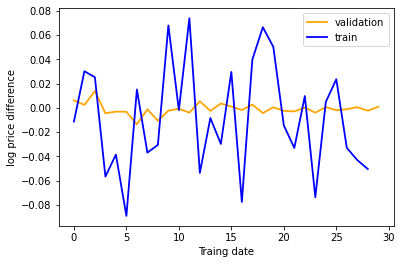

In [73]:
plt.grid()
plt.plot(pred_aal_log, color = 'orange', linewidth =1.8)
plt.plot(aal_close_log_diff.values[586:], color ='b', linewidth =1.8)
plt.xlabel('Traing date')
plt.ylabel('log price difference')
plt.legend(['validation','train'])
plt.grid()
plt.show()

In [74]:
pred_aal_log_full = ARMA_res_aal_log.predict(start = 0, end = 615)
pred_aal_log_full

array([-9.83573129e-04, -6.66781783e-03,  1.71696126e-03,  7.07250771e-03,
        4.23585143e-03,  7.57497163e-04, -4.31247131e-03, -2.94910130e-03,
        3.01714565e-03, -6.90137805e-03,  4.04463750e-04, -3.35493603e-03,
       -1.51040971e-02,  4.40646689e-03,  7.27284548e-03, -1.10102755e-02,
       -7.04211882e-03,  1.42757888e-02,  4.42064897e-03,  6.02772296e-04,
        4.91515028e-04, -5.64456259e-03,  7.70359859e-03, -4.92634546e-03,
       -2.09157452e-02,  3.80365852e-03, -6.87288453e-03,  1.94446435e-03,
       -3.20659496e-05, -1.24779324e-02,  9.26681180e-04, -1.62594972e-04,
        6.91364790e-03,  1.14330081e-02, -7.31681105e-04, -1.56113008e-03,
        7.68704250e-05,  1.74551069e-02,  8.49361531e-03,  1.31487888e-03,
        2.14276745e-02, -2.44092127e-03,  2.26639344e-03, -1.66431403e-02,
       -1.69429927e-02,  4.96494908e-03,  2.99776682e-03, -1.85679094e-02,
       -3.99003041e-02,  7.85564093e-03,  4.20163609e-02, -4.70571576e-02,
       -2.45433727e-02,  

In [75]:
log_aal_close = np.log(aal_close)

In [76]:
#return difference with true close price
pred_aal_log_arima = []
pred_aal_log_arima.append(log_aal_close[0])
for i in range(0,615):
        pred_aal_log_arima.append(pred_aal_log_full[i]+log_aal_close[i])

In [77]:
pred_aal_exp_full = np.exp(pred_aal_log_arima)
pred_aal_exp_full

array([29.09000015, 29.06140208, 27.46624775, 27.36694737, 27.41319535,
       27.95817637, 27.97118083, 27.20243666, 27.3093425 , 27.61318814,
       27.39031521, 28.24141986, 28.30487909, 26.79225637, 27.44064999,
       29.01022071, 27.3373446 , 25.92677678, 27.28677251, 26.91873488,
       27.7367132 , 26.85319566, 27.00712539, 28.64985938, 28.95699626,
       27.71423091, 28.48815255, 28.59280898, 29.89807942, 30.46902228,
       29.71687194, 29.2270724 , 28.62534445, 28.5265422 , 28.83782574,
       27.79965177, 25.410301  , 23.12177815, 22.70284147, 20.77571403,
       19.07506415, 19.2684874 , 17.80648307, 18.57204458, 15.77525415,
       15.70169999, 14.8234151 , 17.0510385 , 15.96087171, 12.92390617,
       14.42285735, 16.60315182, 14.86383198, 11.36754965, 10.41628368,
       10.78299516, 10.67475509, 14.35507954, 15.60812004, 14.53416765,
       13.48173364, 11.87228405, 11.89763076, 10.99213588,  9.86945886,
        9.86928534,  9.83051514, 10.37601354, 11.89920351, 12.04

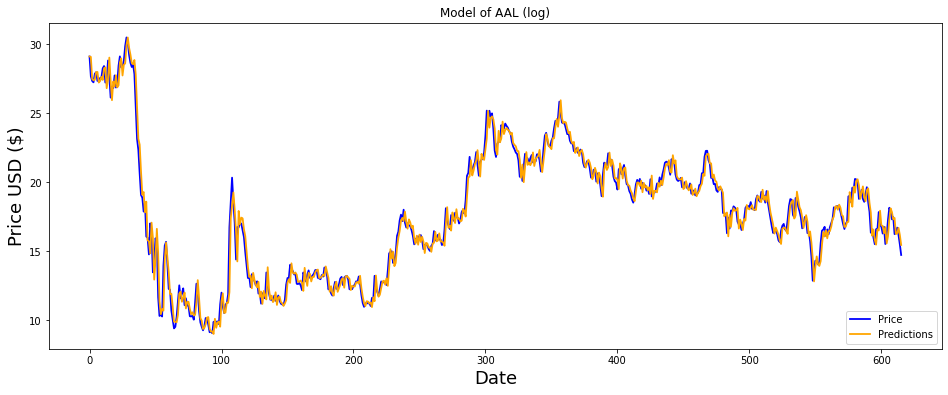

In [78]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model of AAL (log)')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price USD ($)', fontsize=18)
plt.plot(aal_close, label='Price', color = 'b', linewidth =1.8)
plt.plot(pred_aal_exp_full, label='Prediction', color='orange', linewidth =1.8)
plt.legend(['Price', 'Predictions'], loc='lower right')
plt.show()

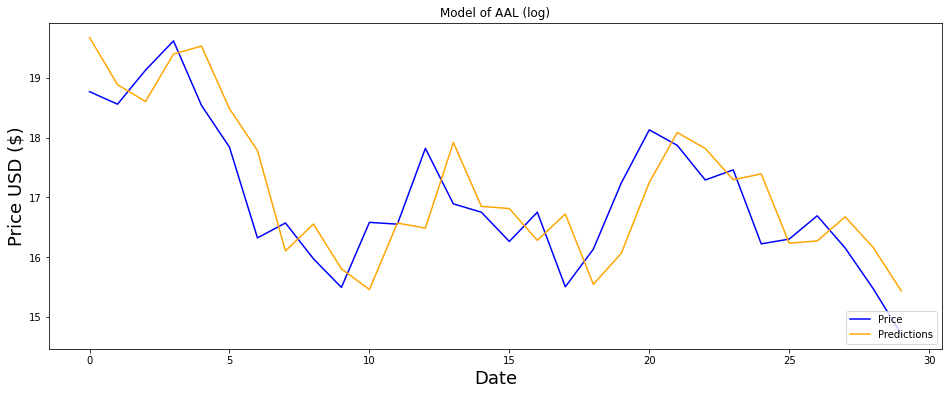

In [79]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model of AAL (log)')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price USD ($)', fontsize=18)
plt.plot(aal_close[training_data_len_aal:], label='Price', color = 'b', linewidth =1.5)
plt.plot(pred_aal_exp_full[training_data_len_aal:], label='Prediction', color='orange', linewidth =1.5)
plt.legend(['Price', 'Predictions'], loc='lower right')
plt.show()

/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


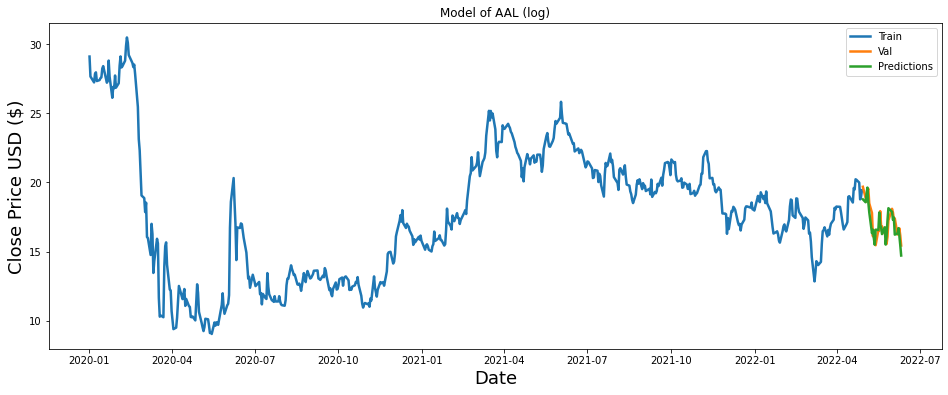

In [80]:
train_aal_arima = df_aal[:training_data_len_aal]
valid_aal_arima = df_aal[training_data_len_aal:]
valid_aal_arima['Predictions'] = pred_aal_exp_full[training_data_len_aal:]
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model of AAL (log)')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train_aal_arima['Close'], linewidth =2.5)
plt.plot(valid_aal_arima[['Predictions','Close']], linewidth =2.5)
plt.legend(['Train', 'Val', 'Predictions'], loc='upper right')
plt.show()

In [81]:
# Get the root mean squared error (RMSE) of testing data
rmse_aal_log_arima = np.sqrt(np.mean(((pred_aal_exp_full - aal_close) ** 2)))
rmse_aal_log_arima

0.7373455160576132

In [82]:
# Get the root mean squared error (RMSE) of training data
rmse_train_aal_log_arima = np.sqrt(np.mean(((pred_aal_exp_full[0:training_data_len_aal] - aal_close[0:training_data_len_aal]) ** 2)))
rmse_train_aal_log_arima

0.7362278243064361

In [83]:
# Get the root mean squared error (RMSE) of testing data
rmse_test_aal_log_arima = np.sqrt(np.mean(((pred_aal_exp_full[training_data_len_aal:] - aal_close[training_data_len_aal:]) ** 2)))
rmse_test_aal_log_arima

0.7588476955475262

# Result of ARIMA model of stock AAL

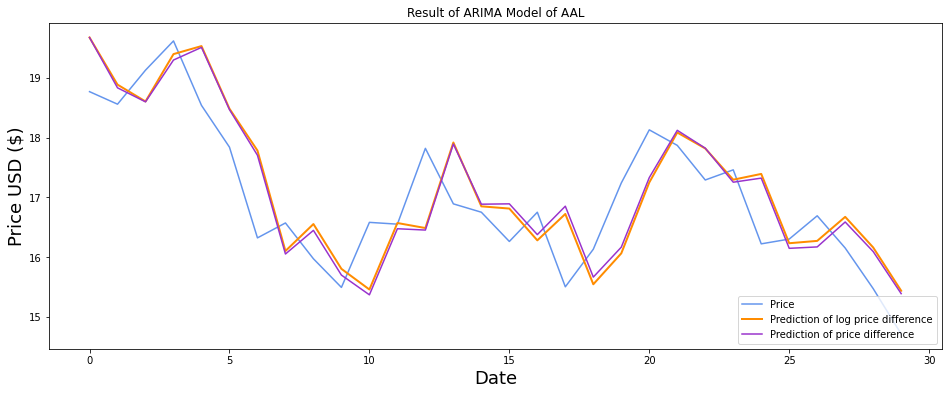

In [84]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Result of ARIMA Model of AAL')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price USD ($)', fontsize=18)
plt.plot(aal_close[training_data_len_aal:], label='Price', color = 'cornflowerblue', linewidth =1.5)
plt.plot(pred_aal_exp_full[training_data_len_aal:], label='Prediction of log price difference', color='darkorange', linewidth =2.0)
plt.plot(pred_aal_arima[training_data_len_aal:], label='Prediction of price difference', color='darkorchid', linewidth =1.5)
plt.legend(['Price', 'Prediction of log price difference','Prediction of price difference'], loc='lower right')
plt.savefig('ARIMA_aal_compare.png', dpi = 500)
plt.show()

# Prediction using ARIMA for stock Delta Airlines(DAL)

In [85]:
#Download data
# Get the stock quote of Delta Airlines
df_delta = yf.download('DAL',  start='2020-01-01', end='2022-06-12')
# Show teh data
df_delta

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,58.930000,59.389999,58.450001,59.040001,58.634808,4459200
2020-01-03,57.500000,58.119999,56.910000,58.060001,57.661533,9078100
2020-01-06,56.990002,57.759998,56.660000,57.660000,57.264275,5504300
2020-01-07,57.910000,58.070000,57.470001,57.610001,57.214619,5563000
2020-01-08,57.750000,59.400002,57.730000,58.849998,58.446106,8519000
...,...,...,...,...,...,...
2022-06-06,39.000000,39.290001,38.310001,39.000000,39.000000,12330400
2022-06-07,38.369999,39.790001,38.250000,39.740002,39.740002,9604700
2022-06-08,38.840000,39.529999,38.169998,38.220001,38.220001,9643000


In [86]:
df_delta.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 616 entries, 2020-01-02 to 2022-06-10
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       616 non-null    float64
 1   High       616 non-null    float64
 2   Low        616 non-null    float64
 3   Close      616 non-null    float64
 4   Adj Close  616 non-null    float64
 5   Volume     616 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 33.7 KB


In [87]:
#Calculate difference the log return
delta_rtn = np.log(df_delta).diff().dropna()
delta_rtn

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-03,-0.024565,-0.021616,-0.026701,-0.016738,-0.016738,0.710896
2020-01-06,-0.008909,-0.006213,-0.004403,-0.006913,-0.006913,-0.500335
2020-01-07,0.016014,0.005353,0.014195,-0.000868,-0.000868,0.010608
2020-01-08,-0.002767,0.022645,0.004514,0.021296,0.021296,0.426161
2020-01-09,0.025811,0.001178,0.014616,0.001867,0.001867,-0.467691
...,...,...,...,...,...,...
2022-06-06,-0.005115,-0.003303,0.006547,0.011865,0.011865,-0.182850
2022-06-07,-0.016286,0.012646,-0.001567,0.018797,0.018797,-0.249815
2022-06-08,0.012175,-0.006556,-0.002094,-0.038999,-0.038999,0.003980


In [88]:
# Convert the data (Close price) to a numpy array
delta_close = np.array(df_delta['Close'])
delta_close

array([59.04000092, 58.06000137, 57.65999985, 57.61000061, 58.84999847,
       58.95999908, 59.24000168, 59.49000168, 61.45000076, 61.61999893,
       61.88000107, 62.02999878, 60.34000015, 59.63999939, 60.27000046,
       58.81000137, 56.83000183, 57.47999954, 56.65000153, 57.09999847,
       55.74000168, 56.04000092, 57.93000031, 58.88999939, 58.18000031,
       57.91999817, 57.70999908, 58.65999985, 59.47000122, 59.13000107,
       58.90000153, 58.72000122, 58.50999832, 58.38000107, 57.86999893,
       54.22999954, 50.88999939, 49.59000015, 48.18999863, 46.13000107,
       47.15999985, 46.18000031, 48.5       , 45.00999832, 45.88999939,
       43.52000046, 45.47000122, 42.66999817, 33.70999908, 38.36000061,
       35.81000137, 31.73999977, 23.48999977, 21.51000023, 21.35000038,
       22.21999931, 26.88999939, 31.10000038, 31.70000076, 29.54999924,
       28.67000008, 28.53000069, 23.87000084, 22.68000031, 22.47999954,
       22.31999969, 22.25      , 23.22999954, 24.38999939, 23.25

In [89]:
# delta_close_diff = delta_close[1:] - delta_close[:-1]
# delta_close_log = np.log(delta_close)
# delta_close_log_diff = delta_close_log[1:] - delta_close_log[:-1]


#Difference of the close price of stock AAL
delta_close_diff = np.array(df_delta['Close'].diff().dropna())

#Log of close price AAL
delta_close_log = np.log(delta_close)
#Difference of thhe log return
delta_close_log_diff = np.log(df_delta['Close']).diff().dropna()


Text(0.5, 1.0, 'Close price of stock DAL')

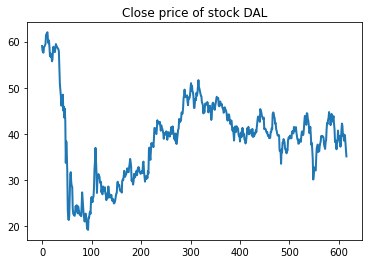

In [90]:
#Plot the close price of stock DAL
plt.plot(delta_close, linewidth = 2)
plt.title('Close price of stock DAL')

Text(0.5, 1.0, 'Difference of the close price of stock DAL')

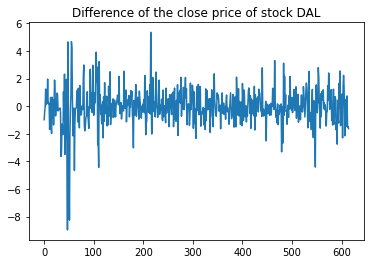

In [91]:
#Plot the difference of the close price of stock DAL
plt.plot(delta_close_diff, linewidth = 1.5)
plt.title('Difference of the close price of stock DAL')

In [92]:
#ADF of close price
result_delta = adfuller(delta_close)
print('ADF Statistic: %f' % result_delta[0])
print('p-value: %f' % result_delta[1])
for key, value in result_delta[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.836251
p-value: 0.053279
	1%: -3.441
	5%: -2.866
	10%: -2.569


ADF Statistic: -2.836251 > critical value 1%: -3.441, 5%: -2.866, 10%: -2.569, so fail to reject the null hypothesis.

p-value = 0.053279 > 0.05(5% significance level or 95% confidence interval), so we fail to reject reject the null hypothesis.
It is non-stationary, and does have time-dependent structure.

In [93]:
#ADF of price difference
result_delta_diff = adfuller(delta_close_diff)
print('ADF Statistic: %f' % result_delta_diff[0])
print('p-value: %f' % result_delta_diff[1])
for key, value in result_delta_diff[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -9.395908
p-value: 0.000000
	1%: -3.441
	5%: -2.866
	10%: -2.569


ADF Statistic:-9.395908 < critical value 1%: -3.441, 5%: -2.866, 10%: -2.569, so we reject the null hypothesis.

p-value = 0.000000 < 0.05(5% significance level or 95% confidence interval), so we reject the null hypothesis.
It is stationary.

In [94]:
#ADF of log price
result_delta_log = adfuller(delta_close_log)
print('ADF Statistic: %f' % result_delta_log[0])
print('p-value: %f' % result_delta_log[1])
for key, value in result_delta_log[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.449098
p-value: 0.128356
	1%: -3.441
	5%: -2.866
	10%: -2.569


ADF Statistic: -2.449098 > critical value 1%: -3.441, 5%: -2.866, 10%: -2.569, so fail to reject the null hypothesis.

p-value = 0.128356 > 0.05(5% significance level or 95% confidence interval), so we fail to reject reject the null hypothesis. It is non-stationary, and does have time-dependent structure.

In [95]:
#ADF of log price difference
result_delta_log_diff = adfuller(delta_close_log_diff)
print('ADF Statistic: %f' % result_delta_log_diff[0])
print('p-value: %f' % result_delta_log_diff[1])
for key, value in result_delta_log_diff[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -9.883333
p-value: 0.000000
	1%: -3.441
	5%: -2.866
	10%: -2.569


ADF Statistic:-9.883333 < critical value 1%: -3.441, 5%: -2.866, 10%: -2.569, so we reject the null hypothesis.

p-value = 0.000000 < 0.05(5% significance level or 95% confidence interval), so we reject the null hypothesis. It is stationary.

In [96]:
def plot_diagnosticsTight2(data, rtn, title1 = 'DAL (Delta)'):

    fig, axes = plt.subplots(1,2,figsize=(15,5))
    axes[0].set_ylabel('ACF', fontsize=15)
    axes[0].set_xlabel('Lag', fontsize=15)
    fig = plot_acf(data,lags=25,zero=True, ax = axes[0], title= 'ACF '+ title1, use_vlines = True)
    axes[1].set_ylabel('ACF', fontsize=15)
    axes[1].set_xlabel('Lag', fontsize=15)
    fig = plot_acf(rtn,lags=25,zero=True, ax = axes[1], title= 'ACF Returns '+ title1, use_vlines = True)
    plt.tight_layout()
    plt.savefig("ACF2.png", dpi = 300)

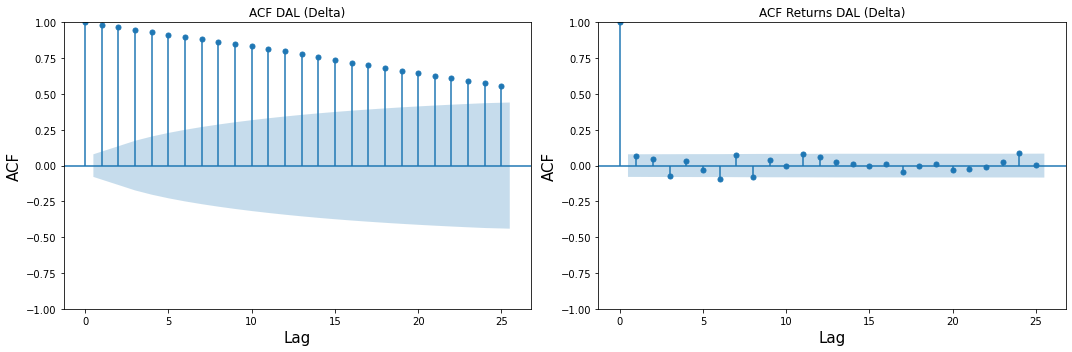

In [97]:
plot_diagnosticsTight2(delta_close,delta_close_diff)

In [98]:
def plot_diagnosticsTight2(data, rtn, title1 = 'DAL (Delta)'):

    fig, axes = plt.subplots(1,2,figsize=(15,5))
    axes[0].set_ylabel('ACF', fontsize=15)
    axes[0].set_xlabel('Lag', fontsize=15)
    fig = plot_acf(data,lags=25,zero=True, ax = axes[0], title= 'ACF log '+ title1, use_vlines = True)
    axes[1].set_ylabel('ACF', fontsize=15)
    axes[1].set_xlabel('Lag', fontsize=15)
    fig = plot_acf(rtn,lags=25,zero=True, ax = axes[1], title= 'ACF log Returns '+ title1, use_vlines = True)
    plt.tight_layout()
    plt.savefig("ACF2.png", dpi = 300)

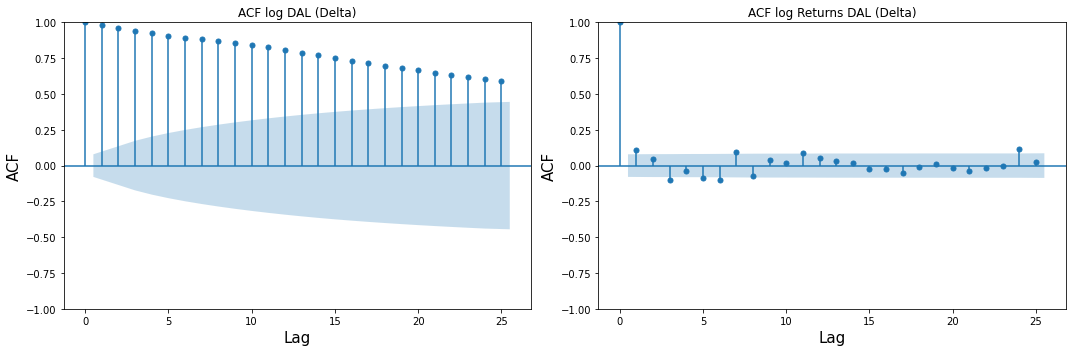

In [99]:
plot_diagnosticsTight2(delta_close_log,delta_close_log_diff)

In [100]:
#Split data to train and test dataset
# Get the number of rows to train the model on
training_data_len_delta =  int(np.ceil( len(dataset_delta) * .95 ))
training_data_len_delta

586

In [101]:
train_diff_delta = delta_close_diff[0:training_data_len_delta]
test_diff_delta = delta_close_diff[training_data_len_delta:]

# Fit model with price difference (DAL)

In [102]:
import pmdarima as pm
from pmdarima.arima.utils import ndiffs

#Find d-value of ARIMA(p,d,q)
d_val_delta = ndiffs(train_diff_delta, test='adf')
print('ARIMA d-value:', d_val_delta)

ARIMA d-value: 0


In [103]:
model_delta = pm.auto_arima(train_diff_delta,
                      d = d_val_delta,
                      start_p = 0,
                      max_p = 10,
                      start_q = 0,
                      max_q = 10,
                      stepwise=False,
                      max_order=30,
                      trace=True)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1983.344, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1982.399, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=1982.739, Time=0.05 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=1981.536, Time=0.06 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=1980.758, Time=0.09 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=1981.233, Time=0.09 sec
 ARIMA(0,0,6)(0,0,0)[1] intercept   : AIC=1979.640, Time=0.12 sec
 ARIMA(0,0,7)(0,0,0)[1] intercept   : AIC=1976.557, Time=0.15 sec
 ARIMA(0,0,8)(0,0,0)[1] intercept   : AIC=1974.160, Time=0.19 sec
 ARIMA(0,0,9)(0,0,0)[1] intercept   : AIC=1975.945, Time=0.19 sec
 ARIMA(0,0,10)(0,0,0)[1] intercept   : AIC=1977.898, Time=0.24 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1982.119, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=1983.762, Time=0.07 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered

 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=1981.752, Time=0.14 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=1982.369, Time=0.24 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,5)(0,0,0)[1] intercept   : AIC=1979.725, Time=0.30 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,6)(0,0,0)[1] intercept   : AIC=1973.141, Time=0.26 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,7)(0,0,0)[1] intercept   : AIC=1974.330, Time=0.35 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,8)(0,0,0)[1] intercept   : AIC=1975.926, Time=0.45 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,9)(0,0,0)[1] intercept   : AIC=1975.223, Time=0.50 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,0,10)(0,0,0)[1] intercept   : AIC=1976.813, Time=0.56 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1983.162, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=1983.439, Time=0.13 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=1972.024, Time=0.16 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=1973.962, Time=0.33 sec
 ARIMA(2,0,4)(0,0,0)[1] intercept   : AIC=1975.816, Time=0.32 sec
 ARIMA(2,0,5)(0,0,0)[1] intercept   : AIC=1974.199, Time=0.62 sec
 ARIMA(2,0,6)(0,0,0)[1] intercept   : AIC=1974.175, Time=0.47 sec
 ARIMA(2,0,7)(0,0,0)[1] intercept   : AIC=1975.585, Time=0.54 sec
 ARIMA(2,0,8)(0,0,0)[1] intercept   : AIC=1977.418, Time=0.80 sec
 ARIMA(2,0,9)(0,0,0)[1] intercept   : AIC=1975.688, Time=1.06 sec
 ARIMA(2,0,10)(0,0,0)[1] intercept   : AIC=1976.369, Time=1.67 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=1982.464, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[1] intercept   : AIC=1983.799, Time=0.13 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,0,2)(0,0,0)[1] intercept   : AIC=1973.780, Time=0.46 sec
 ARIMA(3,0,3)(0,0,0)[1] intercept   : AIC=1976.018, Time=0.22 sec
 ARIMA(3,0,4)(0,0,0)[1] intercept   : AIC=1977.797, Time=0.66 sec
 ARIMA(3,0,5)(0,0,0)[1] intercept   : AIC=1976.932, Time=0.71 sec
 ARIMA(3,0,6)(0,0,0)[1] intercept   : AIC=1976.160, Time=0.71 sec
 ARIMA(3,0,7)(0,0,0)[1] intercept   : AIC=1977.252, Time=0.83 sec
 ARIMA(3,0,8)(0,0,0)[1] intercept   : AIC=inf, Time=1.36 sec
 ARIMA(3,0,9)(0,0,0)[1] intercept   : AIC=1974.992, Time=1.49 sec
 ARIMA(3,0,10)(0,0,0)[1] intercept   : AIC=1977.373, Time=1.72 sec
 ARIMA(4,0,0)(0,0,0)[1] intercept   : AIC=1983.500, Time=0.06 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(4,0,1)(0,0,0)[1] intercept   : AIC=1985.398, Time=0.15 sec
 ARIMA(4,0,2)(0,0,0)[1] intercept   : AIC=1975.844, Time=0.44 sec
 ARIMA(4,0,3)(0,0,0)[1] intercept   : AIC=1975.419, Time=0.64 sec
 ARIMA(4,0,4)(0,0,0)[1] intercept   : AIC=1979.506, Time=0.65 sec
 ARIMA(4,0,5)(0,0,0)[1] intercept   : AIC=1977.223, Time=0.78 sec
 ARIMA(4,0,6)(0,0,0)[1] intercept   : AIC=1973.708, Time=0.96 sec
 ARIMA(4,0,7)(0,0,0)[1] intercept   : AIC=1974.989, Time=1.15 sec
 ARIMA(4,0,8)(0,0,0)[1] intercept   : AIC=1976.682, Time=1.40 sec
 ARIMA(4,0,9)(0,0,0)[1] intercept   : AIC=1975.787, Time=1.50 sec
 ARIMA(4,0,10)(0,0,0)[1] intercept   : AIC=1976.870, Time=1.93 sec
 ARIMA(5,0,0)(0,0,0)[1] intercept   : AIC=1984.866, Time=0.07 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(5,0,1)(0,0,0)[1] intercept   : AIC=1985.674, Time=0.22 sec
 ARIMA(5,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.73 sec
 ARIMA(5,0,3)(0,0,0)[1] intercept   : AIC=1977.755, Time=0.68 sec
 ARIMA(5,0,4)(0,0,0)[1] intercept   : AIC=1977.126, Time=0.84 sec
 ARIMA(5,0,5)(0,0,0)[1] intercept   : AIC=1974.510, Time=0.85 sec
 ARIMA(5,0,6)(0,0,0)[1] intercept   : AIC=1976.501, Time=1.01 sec
 ARIMA(5,0,7)(0,0,0)[1] intercept   : AIC=1976.438, Time=1.23 sec
 ARIMA(5,0,8)(0,0,0)[1] intercept   : AIC=1977.819, Time=1.46 sec
 ARIMA(5,0,9)(0,0,0)[1] intercept   : AIC=1978.337, Time=1.47 sec
 ARIMA(5,0,10)(0,0,0)[1] intercept   : AIC=inf, Time=1.84 sec
 ARIMA(6,0,0)(0,0,0)[1] intercept   : AIC=1981.501, Time=0.08 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(6,0,1)(0,0,0)[1] intercept   : AIC=1974.671, Time=0.25 sec
 ARIMA(6,0,2)(0,0,0)[1] intercept   : AIC=1973.994, Time=0.47 sec
 ARIMA(6,0,3)(0,0,0)[1] intercept   : AIC=1975.994, Time=0.62 sec
 ARIMA(6,0,4)(0,0,0)[1] intercept   : AIC=1977.628, Time=0.82 sec
 ARIMA(6,0,5)(0,0,0)[1] intercept   : AIC=1975.618, Time=0.99 sec
 ARIMA(6,0,6)(0,0,0)[1] intercept   : AIC=1974.897, Time=1.11 sec
 ARIMA(6,0,7)(0,0,0)[1] intercept   : AIC=1976.801, Time=1.24 sec
 ARIMA(6,0,8)(0,0,0)[1] intercept   : AIC=1974.851, Time=1.52 sec
 ARIMA(6,0,9)(0,0,0)[1] intercept   : AIC=1976.653, Time=1.60 sec
 ARIMA(6,0,10)(0,0,0)[1] intercept   : AIC=1979.279, Time=2.15 sec
 ARIMA(7,0,0)(0,0,0)[1] intercept   : AIC=1977.856, Time=0.12 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(7,0,1)(0,0,0)[1] intercept   : AIC=1975.371, Time=0.28 sec
 ARIMA(7,0,2)(0,0,0)[1] intercept   : AIC=1975.994, Time=0.60 sec
 ARIMA(7,0,3)(0,0,0)[1] intercept   : AIC=1977.368, Time=0.94 sec
 ARIMA(7,0,4)(0,0,0)[1] intercept   : AIC=1979.625, Time=0.92 sec
 ARIMA(7,0,5)(0,0,0)[1] intercept   : AIC=1976.705, Time=1.09 sec
 ARIMA(7,0,6)(0,0,0)[1] intercept   : AIC=1976.662, Time=1.15 sec
 ARIMA(7,0,7)(0,0,0)[1] intercept   : AIC=1977.877, Time=1.45 sec
 ARIMA(7,0,8)(0,0,0)[1] intercept   : AIC=1977.181, Time=1.55 sec
 ARIMA(7,0,9)(0,0,0)[1] intercept   : AIC=inf, Time=1.74 sec
 ARIMA(7,0,10)(0,0,0)[1] intercept   : AIC=1980.536, Time=2.02 sec
 ARIMA(8,0,0)(0,0,0)[1] intercept   : AIC=1974.217, Time=0.15 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(8,0,1)(0,0,0)[1] intercept   : AIC=1975.876, Time=0.29 sec
 ARIMA(8,0,2)(0,0,0)[1] intercept   : AIC=1977.748, Time=0.85 sec
 ARIMA(8,0,3)(0,0,0)[1] intercept   : AIC=1974.625, Time=1.19 sec
 ARIMA(8,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=1.21 sec
 ARIMA(8,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=1.39 sec
 ARIMA(8,0,6)(0,0,0)[1] intercept   : AIC=1978.234, Time=1.24 sec
 ARIMA(8,0,7)(0,0,0)[1] intercept   : AIC=inf, Time=1.41 sec
 ARIMA(8,0,8)(0,0,0)[1] intercept   : AIC=1978.466, Time=1.64 sec
 ARIMA(8,0,9)(0,0,0)[1] intercept   : AIC=inf, Time=1.78 sec
 ARIMA(8,0,10)(0,0,0)[1] intercept   : AIC=inf, Time=2.18 sec
 ARIMA(9,0,0)(0,0,0)[1] intercept   : AIC=1975.693, Time=0.19 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(9,0,1)(0,0,0)[1] intercept   : AIC=1974.265, Time=0.76 sec
 ARIMA(9,0,2)(0,0,0)[1] intercept   : AIC=1975.218, Time=1.07 sec
 ARIMA(9,0,3)(0,0,0)[1] intercept   : AIC=1976.090, Time=1.61 sec
 ARIMA(9,0,4)(0,0,0)[1] intercept   : AIC=1975.696, Time=1.47 sec
 ARIMA(9,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=1.80 sec
 ARIMA(9,0,6)(0,0,0)[1] intercept   : AIC=inf, Time=1.70 sec
 ARIMA(9,0,7)(0,0,0)[1] intercept   : AIC=1980.881, Time=1.63 sec
 ARIMA(9,0,8)(0,0,0)[1] intercept   : AIC=inf, Time=1.82 sec
 ARIMA(9,0,9)(0,0,0)[1] intercept   : AIC=inf, Time=1.93 sec
 ARIMA(9,0,10)(0,0,0)[1] intercept   : AIC=inf, Time=2.36 sec
 ARIMA(10,0,0)(0,0,0)[1] intercept   : AIC=1977.109, Time=0.21 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(10,0,1)(0,0,0)[1] intercept   : AIC=1975.849, Time=0.73 sec
 ARIMA(10,0,2)(0,0,0)[1] intercept   : AIC=1977.394, Time=1.44 sec
 ARIMA(10,0,3)(0,0,0)[1] intercept   : AIC=1979.097, Time=0.85 sec
 ARIMA(10,0,4)(0,0,0)[1] intercept   : AIC=1979.716, Time=1.56 sec
 ARIMA(10,0,5)(0,0,0)[1] intercept   : AIC=1981.049, Time=1.68 sec
 ARIMA(10,0,6)(0,0,0)[1] intercept   : AIC=inf, Time=1.80 sec
 ARIMA(10,0,7)(0,0,0)[1] intercept   : AIC=1984.376, Time=1.83 sec
 ARIMA(10,0,8)(0,0,0)[1] intercept   : AIC=inf, Time=1.88 sec
 ARIMA(10,0,9)(0,0,0)[1] intercept   : AIC=inf, Time=1.87 sec
 ARIMA(10,0,10)(0,0,0)[1] intercept   : AIC=inf, Time=2.43 sec

Best model:  ARIMA(2,0,2)(0,0,0)[1] intercept
Total fit time: 107.794 seconds


In [104]:
model_delta.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  586
Model:               SARIMAX(2, 0, 2)   Log Likelihood                -980.012
Date:                Mon, 12 Dec 2022   AIC                           1972.024
Time:                        00:04:20   BIC                           1998.264
Sample:                             0   HQIC                          1982.249
                                - 586                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0779      0.170     -0.458      0.647      -0.412       0.256
ar.L1         -1.0869      0.072    -15.055      0.000      -1.228      -0.945
ar.L2         -0.6963      0.071     -9.824      0.000      -0.835      -0.557
ma.L1          1.1719      0.065     18.091      0.000       1.045       1.299
ma.L2          0.8283      0.065     12.677      0.000       0.700       0.956
sigma2         1.6595      0.052     31.623      0.000       1.557       1.762
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               950.52
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.41   Skew:                            -0.59
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [105]:
model_delta_arima = ARIMA(train_diff_delta, order=(2,0,2))
ARMA_res_delta = model_delta_arima.fit()
print(ARMA_res_delta.summary());

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  586
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -980.012
Date:                Mon, 12 Dec 2022   AIC                           1972.024
Time:                        00:04:21   BIC                           1998.264
Sample:                             0   HQIC                          1982.249
                                - 586                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0280      0.061     -0.460      0.646      -0.147       0.091
ar.L1         -1.0869      0.072    -15.055      0.000      -1.228      -0.945
ar.L2         -0.6963      0.071     -9.824      0.0

In [106]:
pred_delta = ARMA_res_delta.predict(start = 586, end = 615)
pred_delta

array([-0.30298637, -0.05191619,  0.18946716, -0.24771077,  0.0593737 ,
        0.03001911, -0.15190131,  0.06626492, -0.04418377, -0.0760498 ,
        0.03549121, -0.06355235, -0.03357042,  0.00280755, -0.05760774,
       -0.01727361, -0.01904447, -0.04520474, -0.01553849, -0.02956665,
       -0.03497652, -0.0193287 , -0.03256913, -0.02907403, -0.02365337,
       -0.03197866, -0.02670448, -0.02663994, -0.03038255, -0.02635971])

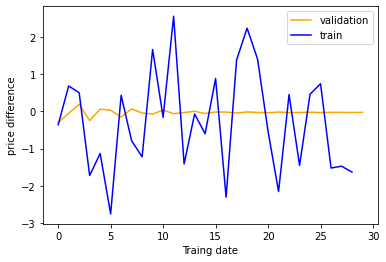

In [107]:
plt.grid()
plt.plot(pred_delta, color = 'orange', linewidth =1.5)
plt.plot(delta_close_diff[586:], color ='b', linewidth =1.5)
plt.xlabel('Traing date')
plt.ylabel('price difference')
plt.legend(['validation','train'])
plt.grid()
plt.show()

In [108]:
def plot_diagnosticsTight3(data):

    fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,6))
    
    ax1.hist(data, bins =40,color='m', density = True)  
    mu = data.mean()
    sigma = data.std()
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 2419)
    ax1.plot(x, stats.norm.pdf(x, mu, sigma), linewidth= 5)
    ax1.grid()
    ax1.set_title("Hist Resid")
    
    ax2.plot(data)
    ax2.grid()
    ax2.set_title("Resid")
    
    fig = plot_acf(data,lags=40,zero=False, ax = ax3,use_vlines = True)
    ax3.grid()
    
   
    
    
    fig = sm.qqplot(data, line='q', ax = ax4)
    ax4.grid()
    
   
    plt.tight_layout()


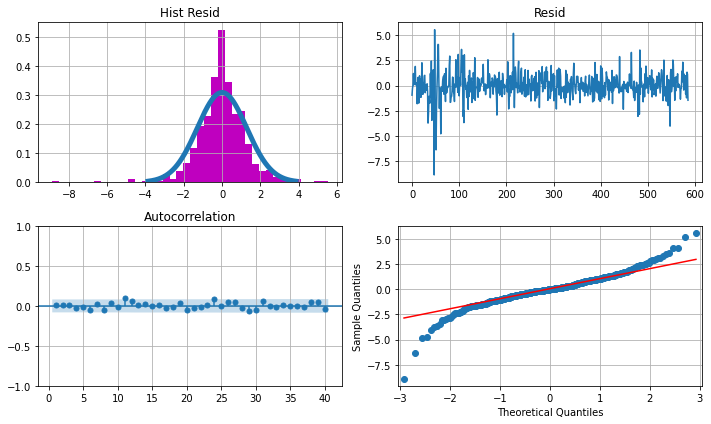

In [109]:
resid_delta = ARMA_res_delta.resid
plot_diagnosticsTight3(resid_delta)

In [110]:
pred_delta_full = ARMA_res_delta.predict(start = 0, end = 615)
pred_delta_full

array([-2.80008035e-02, -9.24372758e-02, -7.80755930e-02,  3.98128318e-02,
        2.60085220e-02,  1.06238744e-02, -7.71377721e-02,  5.64739949e-02,
        1.07683768e-01,  8.35092695e-03, -1.33833184e-01,  1.16811433e-01,
       -2.25338119e-01, -1.86360111e-01,  2.88090206e-01, -3.02335556e-01,
       -3.17969674e-01,  3.40428721e-01, -1.98778167e-01, -1.97123460e-01,
        2.61614000e-01, -3.74386642e-01,  3.43626985e-01,  1.59109966e-01,
       -4.82661063e-01,  2.40382000e-01, -1.20356501e-02, -2.09909710e-01,
        3.71945687e-01, -2.62086074e-01, -1.43187871e-01,  2.61293893e-01,
       -3.07119995e-01,  2.68272718e-02,  8.45015125e-02, -5.75798911e-01,
       -2.37246534e-01,  1.25833719e-01, -3.19428153e-01, -1.67660347e-01,
        1.98861730e-01, -1.19508375e-01, -3.46846702e-02,  7.11507441e-02,
       -5.18321796e-01,  3.85197064e-01, -2.47011291e-01, -8.82241715e-02,
       -9.01245829e-01,  2.64196986e-01,  7.55804753e-01, -1.86505769e+00,
        2.43164505e-01, -

In [111]:
#return difference with true close price
pred_delta_arima = []
pred_delta_arima.append(delta_close[0])
for i in range(0,615):
        pred_delta_arima.append(pred_delta_full[i]+delta_close[i])

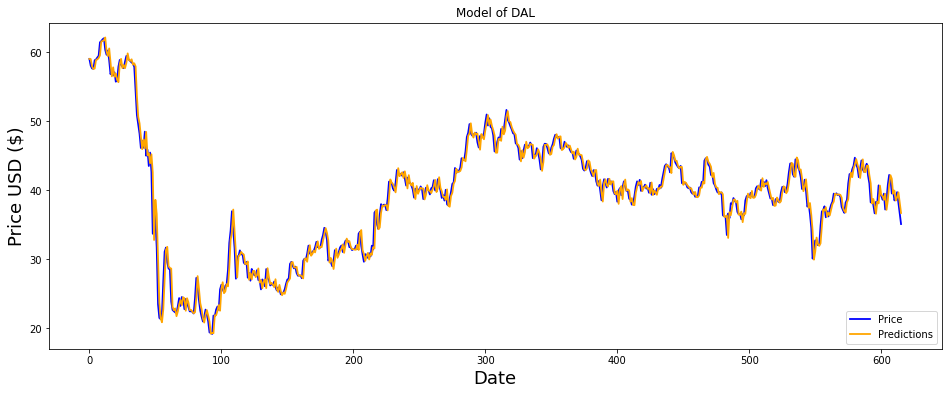

In [112]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model of DAL')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price USD ($)', fontsize=18)
plt.plot(delta_close, label='Price', color = 'b', linewidth=1.8)
plt.plot(pred_delta_arima, label='Prediction', color='orange', linewidth=1.8)
plt.legend(['Price', 'Predictions'], loc='lower right')
plt.show()

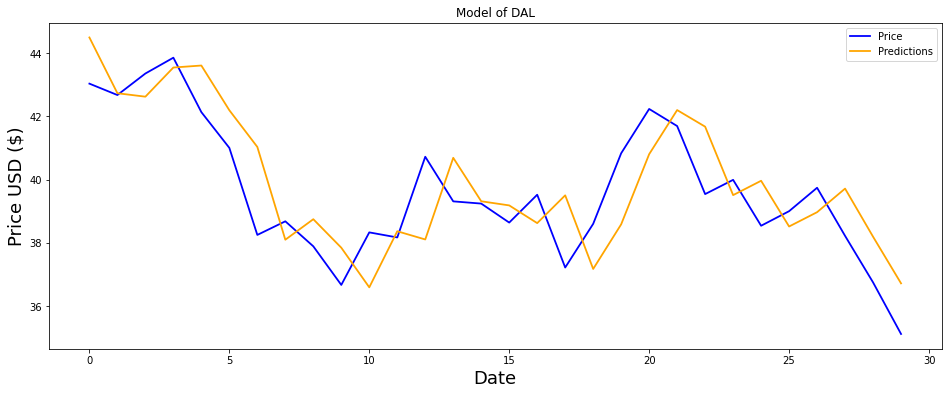

In [113]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model of DAL')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price USD ($)', fontsize=18)
plt.plot(delta_close[training_data_len_delta:], label='Price', color = 'b', linewidth=1.8)
plt.plot(pred_delta_arima[training_data_len_delta:], label='Prediction', color='orange', linewidth=1.8)
plt.legend(['Price', 'Predictions'], loc='upper right')
plt.show()

/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


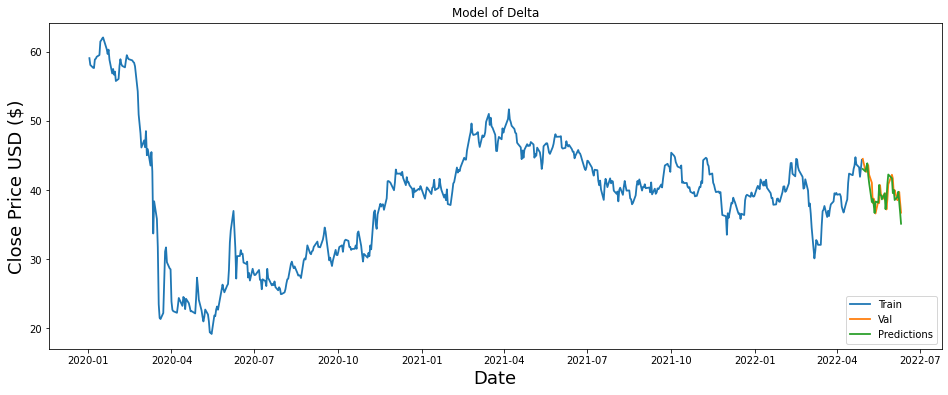

In [114]:
train_delta_arima = df_delta[:training_data_len_delta]
valid_delta_arima = df_delta[training_data_len_delta:]
valid_delta_arima['Predictions'] = pred_delta_arima[training_data_len_delta:]
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model of Delta')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train_delta_arima['Close'], linewidth=1.8)
plt.plot(valid_delta_arima[['Predictions', 'Close']], linewidth=1.8)
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [115]:
# Get the root mean squared error (RMSE) of full delta
rmse_delta_arima = np.sqrt(np.mean(((pred_delta_arima - delta_close) ** 2)))
rmse_delta_arima

1.2924370946903088

In [116]:
# Get the root mean squared error (RMSE) of training data
rmse_train_delta_arima = np.sqrt(np.mean(((pred_delta_arima[0:training_data_len_delta] - delta_close[0:training_data_len_delta]) ** 2)))
rmse_train_delta_arima

1.286900815311626

In [117]:
# Get the root mean squared error (RMSE) of training data
rmse_test_delta_arima = np.sqrt(np.mean(((pred_delta_arima[training_data_len_delta:] - delta_close[training_data_len_delta:]) ** 2)))
rmse_test_delta_arima

1.3961835049768103

# Fit model with log price difference(DAL)

In [118]:
train_diff_delta_log = delta_close_log_diff[0:training_data_len_delta]
test_diff_delta_log = delta_close_log_diff[training_data_len_delta:]

In [119]:
import pmdarima as pm
from pmdarima.arima.utils import ndiffs

#Find d-value of ARIMA(p,d,q)
d_val_delta_log_diff = ndiffs(train_diff_delta_log, test='adf')
print('ARIMA d-value:', d_val_delta_log_diff)

ARIMA d-value: 0


In [120]:
train_diff_delta_log = np.asarray(train_diff_delta_log)

In [121]:
model_delta_log = pm.auto_arima(train_diff_delta_log,
                      d = d_val_delta_log_diff,
                      start_p = 0,
                      max_p = 10,
                      start_q = 0,
                      max_q = 10,
                      stepwise=False,
                      max_order=30,
                      trace=True)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=-2138.804, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=-2144.069, Time=0.11 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=-2144.904, Time=0.15 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=-2149.032, Time=0.26 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=-2147.381, Time=0.28 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=-2151.788, Time=0.44 sec
 ARIMA(0,0,6)(0,0,0)[1] intercept   : AIC=-2155.304, Time=0.42 sec
 ARIMA(0,0,7)(0,0,0)[1] intercept   : AIC=-2164.376, Time=0.55 sec
 ARIMA(0,0,8)(0,0,0)[1] intercept   : AIC=-2164.457, Time=0.64 sec
 ARIMA(0,0,9)(0,0,0)[1] intercept   : AIC=-2162.627, Time=0.54 sec
 ARIMA(0,0,10)(0,0,0)[1] intercept   : AIC=-2161.493, Time=1.37 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=-2144.810, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=-2142.882, Time=0.04 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=-2146.150, Time=0.28 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=-2146.787, Time=0.28 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=-2145.986, Time=0.54 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,5)(0,0,0)[1] intercept   : AIC=-2149.974, Time=0.56 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,6)(0,0,0)[1] intercept   : AIC=-2164.250, Time=0.73 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,7)(0,0,0)[1] intercept   : AIC=-2164.274, Time=0.85 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,8)(0,0,0)[1] intercept   : AIC=-2161.190, Time=1.01 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,9)(0,0,0)[1] intercept   : AIC=-2162.916, Time=1.12 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,10)(0,0,0)[1] intercept   : AIC=-2161.875, Time=1.30 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=-2143.477, Time=0.04 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=-2143.803, Time=0.39 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=-2157.052, Time=0.43 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=-2147.123, Time=0.43 sec
 ARIMA(2,0,4)(0,0,0)[1] intercept   : AIC=-2143.920, Time=0.56 sec
 ARIMA(2,0,5)(0,0,0)[1] intercept   : AIC=-2152.617, Time=0.64 sec
 ARIMA(2,0,6)(0,0,0)[1] intercept   : AIC=-2161.631, Time=0.79 sec
 ARIMA(2,0,7)(0,0,0)[1] intercept   : AIC=-2163.258, Time=0.74 sec
 ARIMA(2,0,8)(0,0,0)[1] intercept   : AIC=-2161.487, Time=1.09 sec
 ARIMA(2,0,9)(0,0,0)[1] intercept   : AIC=-2160.922, Time=1.22 sec
 ARIMA(2,0,10)(0,0,0)[1] intercept   : AIC=-2159.985, Time=1.48 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=-2148.410, Time=0.10 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,0,1)(0,0,0)[1] intercept   : AIC=-2146.301, Time=0.17 sec
 ARIMA(3,0,2)(0,0,0)[1] intercept   : AIC=-2145.287, Time=0.46 sec
 ARIMA(3,0,3)(0,0,0)[1] intercept   : AIC=-2151.654, Time=0.51 sec
 ARIMA(3,0,4)(0,0,0)[1] intercept   : AIC=-2154.621, Time=0.60 sec
 ARIMA(3,0,5)(0,0,0)[1] intercept   : AIC=-2155.031, Time=0.76 sec
 ARIMA(3,0,6)(0,0,0)[1] intercept   : AIC=-2159.707, Time=0.84 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(3,0,7)(0,0,0)[1] intercept   : AIC=-2161.663, Time=0.73 sec
 ARIMA(3,0,8)(0,0,0)[1] intercept   : AIC=-2158.642, Time=1.26 sec
 ARIMA(3,0,9)(0,0,0)[1] intercept   : AIC=-2160.135, Time=1.44 sec
 ARIMA(3,0,10)(0,0,0)[1] intercept   : AIC=-2160.031, Time=1.62 sec
 ARIMA(4,0,0)(0,0,0)[1] intercept   : AIC=-2146.560, Time=0.23 sec
 ARIMA(4,0,1)(0,0,0)[1] intercept   : AIC=-2144.490, Time=0.07 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(4,0,2)(0,0,0)[1] intercept   : AIC=-2144.599, Time=0.52 sec
 ARIMA(4,0,3)(0,0,0)[1] intercept   : AIC=-2146.380, Time=0.61 sec
 ARIMA(4,0,4)(0,0,0)[1] intercept   : AIC=-2153.481, Time=0.71 sec
 ARIMA(4,0,5)(0,0,0)[1] intercept   : AIC=-2155.402, Time=0.81 sec
 ARIMA(4,0,6)(0,0,0)[1] intercept   : AIC=-2156.114, Time=0.90 sec
 ARIMA(4,0,7)(0,0,0)[1] intercept   : AIC=-2159.626, Time=1.15 sec
 ARIMA(4,0,8)(0,0,0)[1] intercept   : AIC=-2158.064, Time=1.34 sec
 ARIMA(4,0,9)(0,0,0)[1] intercept   : AIC=-2157.810, Time=1.38 sec
 ARIMA(4,0,10)(0,0,0)[1] intercept   : AIC=-2158.103, Time=1.65 sec
 ARIMA(5,0,0)(0,0,0)[1] intercept   : AIC=-2148.191, Time=0.08 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(5,0,1)(0,0,0)[1] intercept   : AIC=-2147.665, Time=0.55 sec
 ARIMA(5,0,2)(0,0,0)[1] intercept   : AIC=-2145.330, Time=0.60 sec
 ARIMA(5,0,3)(0,0,0)[1] intercept   : AIC=-2149.368, Time=0.69 sec
 ARIMA(5,0,4)(0,0,0)[1] intercept   : AIC=-2155.483, Time=0.78 sec
 ARIMA(5,0,5)(0,0,0)[1] intercept   : AIC=-2154.883, Time=0.84 sec
 ARIMA(5,0,6)(0,0,0)[1] intercept   : AIC=-2155.163, Time=0.97 sec
 ARIMA(5,0,7)(0,0,0)[1] intercept   : AIC=-2159.871, Time=1.15 sec
 ARIMA(5,0,8)(0,0,0)[1] intercept   : AIC=-2159.580, Time=1.34 sec
 ARIMA(5,0,9)(0,0,0)[1] intercept   : AIC=-2158.500, Time=1.52 sec
 ARIMA(5,0,10)(0,0,0)[1] intercept   : AIC=-2156.066, Time=2.10 sec
 ARIMA(6,0,0)(0,0,0)[1] intercept   : AIC=-2151.202, Time=0.09 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(6,0,1)(0,0,0)[1] intercept   : AIC=-2160.823, Time=0.67 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(6,0,2)(0,0,0)[1] intercept   : AIC=-2159.851, Time=0.72 sec
 ARIMA(6,0,3)(0,0,0)[1] intercept   : AIC=-2155.352, Time=0.83 sec
 ARIMA(6,0,4)(0,0,0)[1] intercept   : AIC=-2161.075, Time=0.88 sec
 ARIMA(6,0,5)(0,0,0)[1] intercept   : AIC=-2158.798, Time=0.93 sec
 ARIMA(6,0,6)(0,0,0)[1] intercept   : AIC=-2153.958, Time=1.02 sec
 ARIMA(6,0,7)(0,0,0)[1] intercept   : AIC=-2160.115, Time=1.28 sec
 ARIMA(6,0,8)(0,0,0)[1] intercept   : AIC=-2160.428, Time=1.53 sec
 ARIMA(6,0,9)(0,0,0)[1] intercept   : AIC=-2157.909, Time=1.55 sec
 ARIMA(6,0,10)(0,0,0)[1] intercept   : AIC=-2155.541, Time=1.93 sec
 ARIMA(7,0,0)(0,0,0)[1] intercept   : AIC=-2158.689, Time=0.22 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(7,0,1)(0,0,0)[1] intercept   : AIC=-2162.215, Time=0.82 sec
 ARIMA(7,0,2)(0,0,0)[1] intercept   : AIC=-2159.011, Time=0.89 sec
 ARIMA(7,0,3)(0,0,0)[1] intercept   : AIC=-2159.805, Time=0.97 sec
 ARIMA(7,0,4)(0,0,0)[1] intercept   : AIC=-2159.136, Time=1.02 sec
 ARIMA(7,0,5)(0,0,0)[1] intercept   : AIC=-2155.357, Time=1.14 sec
 ARIMA(7,0,6)(0,0,0)[1] intercept   : AIC=-2157.785, Time=1.17 sec
 ARIMA(7,0,7)(0,0,0)[1] intercept   : AIC=-2158.801, Time=1.34 sec
 ARIMA(7,0,8)(0,0,0)[1] intercept   : AIC=-2158.427, Time=1.66 sec
 ARIMA(7,0,9)(0,0,0)[1] intercept   : AIC=-2156.121, Time=1.73 sec
 ARIMA(7,0,10)(0,0,0)[1] intercept   : AIC=-2153.638, Time=2.01 sec
 ARIMA(8,0,0)(0,0,0)[1] intercept   : AIC=-2164.455, Time=0.39 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(8,0,1)(0,0,0)[1] intercept   : AIC=-2162.587, Time=0.43 sec
 ARIMA(8,0,2)(0,0,0)[1] intercept   : AIC=-2161.046, Time=1.00 sec
 ARIMA(8,0,3)(0,0,0)[1] intercept   : AIC=-2159.046, Time=1.10 sec
 ARIMA(8,0,4)(0,0,0)[1] intercept   : AIC=-2157.000, Time=1.21 sec
 ARIMA(8,0,5)(0,0,0)[1] intercept   : AIC=-2155.139, Time=1.29 sec
 ARIMA(8,0,6)(0,0,0)[1] intercept   : AIC=-2159.261, Time=1.32 sec
 ARIMA(8,0,7)(0,0,0)[1] intercept   : AIC=-2158.274, Time=1.36 sec
 ARIMA(8,0,8)(0,0,0)[1] intercept   : AIC=-2156.549, Time=1.72 sec
 ARIMA(8,0,9)(0,0,0)[1] intercept   : AIC=-2153.149, Time=1.95 sec
 ARIMA(8,0,10)(0,0,0)[1] intercept   : AIC=-2151.648, Time=2.27 sec
 ARIMA(9,0,0)(0,0,0)[1] intercept   : AIC=-2162.731, Time=0.60 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(9,0,1)(0,0,0)[1] intercept   : AIC=-2160.651, Time=0.64 sec
 ARIMA(9,0,2)(0,0,0)[1] intercept   : AIC=-2159.287, Time=1.23 sec
 ARIMA(9,0,3)(0,0,0)[1] intercept   : AIC=-2157.177, Time=1.23 sec
 ARIMA(9,0,4)(0,0,0)[1] intercept   : AIC=-2155.235, Time=1.50 sec
 ARIMA(9,0,5)(0,0,0)[1] intercept   : AIC=-2153.208, Time=1.56 sec
 ARIMA(9,0,6)(0,0,0)[1] intercept   : AIC=-2153.023, Time=1.65 sec
 ARIMA(9,0,7)(0,0,0)[1] intercept   : AIC=-2155.369, Time=1.61 sec
 ARIMA(9,0,8)(0,0,0)[1] intercept   : AIC=-2153.550, Time=1.69 sec
 ARIMA(9,0,9)(0,0,0)[1] intercept   : AIC=-2150.008, Time=2.14 sec
 ARIMA(9,0,10)(0,0,0)[1] intercept   : AIC=-2149.394, Time=2.26 sec
 ARIMA(10,0,0)(0,0,0)[1] intercept   : AIC=-2162.366, Time=0.67 sec


/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(10,0,1)(0,0,0)[1] intercept   : AIC=-2160.543, Time=1.22 sec
 ARIMA(10,0,2)(0,0,0)[1] intercept   : AIC=-2159.889, Time=1.35 sec
 ARIMA(10,0,3)(0,0,0)[1] intercept   : AIC=-2158.564, Time=1.49 sec
 ARIMA(10,0,4)(0,0,0)[1] intercept   : AIC=-2154.112, Time=1.64 sec
 ARIMA(10,0,5)(0,0,0)[1] intercept   : AIC=-2152.406, Time=1.76 sec
 ARIMA(10,0,6)(0,0,0)[1] intercept   : AIC=-2086.590, Time=1.97 sec
 ARIMA(10,0,7)(0,0,0)[1] intercept   : AIC=-2151.608, Time=1.87 sec
 ARIMA(10,0,8)(0,0,0)[1] intercept   : AIC=-2151.351, Time=1.90 sec
 ARIMA(10,0,9)(0,0,0)[1] intercept   : AIC=-2147.746, Time=2.06 sec
 ARIMA(10,0,10)(0,0,0)[1] intercept   : AIC=-2151.599, Time=2.28 sec

Best model:  ARIMA(0,0,8)(0,0,0)[1] intercept
Total fit time: 120.668 seconds


In [122]:
model_delta_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  586
Model:               SARIMAX(0, 0, 8)   Log Likelihood                1092.229
Date:                Mon, 12 Dec 2022   AIC                          -2164.457
Time:                        00:06:22   BIC                          -2120.724
Sample:                             0   HQIC                         -2147.415
                                - 586                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0006      0.002     -0.343      0.732      -0.004       0.003
ma.L1          0.1364      0.024      5.682      0.000       0.089       0.183
ma.L2          0.0570      0.031      1.815      0.070      -0.005       0.118
ma.L3         -0.1111      0.029     -3.836      0.000      -0.168      -0.054
ma.L4         -0.0117      0.026     -0.453      0.651      -0.062       0.039
ma.L5         -0.0841      0.027     -3.124      0.002      -0.137      -0.031
ma.L6         -0.1013      0.035     -2.893      0.004      -0.170      -0.033
ma.L7          0.1292      0.034      3.816      0.000       0.063       0.196
ma.L8         -0.0601      0.034     -1.766      0.077      -0.127       0.007
sigma2         0.0014   4.84e-05     29.046      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1631.54
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.30   Skew:                            -0.71
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [123]:
model_delta_arima_log = ARIMA(train_diff_delta_log, order=(0,0,8))
ARMA_res_delta_log = model_delta_arima_log.fit()
print(ARMA_res_delta_log.summary());

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  586
Model:                 ARIMA(0, 0, 8)   Log Likelihood                1092.229
Date:                Mon, 12 Dec 2022   AIC                          -2164.457
Time:                        00:06:23   BIC                          -2120.724
Sample:                             0   HQIC                         -2147.415
                                - 586                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.002     -0.343      0.732      -0.004       0.003
ma.L1          0.1363      0.024      5.681      0.000       0.089       0.183
ma.L2          0.0570      0.031      1.815      0.0

In [124]:
pred_delta_log = ARMA_res_delta_log.predict(start = 586, end = 615)
pred_delta_log

array([-0.00393106, -0.00562723,  0.00197566, -0.00852561,  0.00673312,
        0.00374216, -0.00665234,  0.00163619, -0.00056402, -0.00056402,
       -0.00056402, -0.00056402, -0.00056402, -0.00056402, -0.00056402,
       -0.00056402, -0.00056402, -0.00056402, -0.00056402, -0.00056402,
       -0.00056402, -0.00056402, -0.00056402, -0.00056402, -0.00056402,
       -0.00056402, -0.00056402, -0.00056402, -0.00056402, -0.00056402])

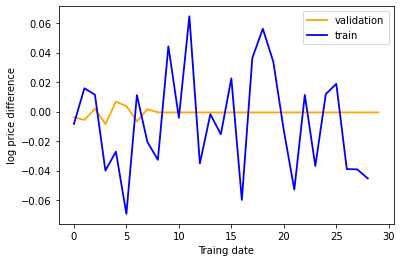

In [125]:
plt.grid()
plt.plot(pred_delta_log, color = 'orange', linewidth=1.8)
plt.plot(delta_close_log_diff.values[586:], color ='b', linewidth=1.8)
plt.xlabel('Traing date')
plt.ylabel('log price difference')
plt.legend(['validation','train'])
plt.grid()
plt.show()

In [126]:
pred_delta_log_full = ARMA_res_delta_log.predict(start = 0, end = 615)
pred_delta_log_full

array([-5.64017516e-04, -2.49152959e-03, -1.78270678e-03,  8.46561002e-04,
        2.92853682e-03,  1.65193578e-03, -7.00473718e-04, -1.47535302e-03,
        2.55486507e-03, -7.60701392e-04, -1.26532260e-03, -2.32471866e-03,
       -7.17349619e-03, -5.97041839e-03,  7.70167337e-03, -5.99090306e-03,
       -5.61075888e-03,  6.60118692e-03, -3.36306199e-03,  2.09517084e-04,
        6.92845301e-03, -6.86917660e-03,  5.71416921e-03,  8.71484756e-03,
       -1.00668621e-02,  2.66989451e-03, -5.94294163e-03, -1.96457810e-03,
        9.40862605e-03, -3.51206905e-03, -6.85227645e-03,  2.16726630e-03,
       -5.63813570e-03,  2.09759895e-03,  9.97943895e-04, -1.36659609e-02,
       -8.99824816e-03,  2.55566276e-03,  1.33941707e-04,  1.58115751e-03,
        1.26728117e-02, -1.44898623e-04,  4.30393154e-03,  2.63326840e-03,
       -8.15146100e-03, -5.60109845e-04,  6.54872365e-03, -6.71819892e-03,
       -2.52188099e-02,  3.64925863e-03,  3.23272770e-02, -4.54329849e-02,
       -3.07387530e-03, -

In [127]:
log_delta_close = np.log(delta_close)

In [128]:
#return difference with true close price
pred_delta_log_arima = []
pred_delta_log_arima.append(log_delta_close[0])
for i in range(0,615):
        pred_delta_log_arima.append(pred_delta_log_full[i]+log_delta_close[i])

In [129]:
pred_delta_exp_full = np.exp(pred_delta_log_arima)
pred_delta_exp_full

array([59.04000092, 59.00671071, 57.91552322, 57.55730054, 57.65879164,
       59.02259547, 59.05747771, 59.19852014, 59.40229764, 61.60719795,
       61.57314234, 61.80175242, 61.88596397, 59.90870021, 59.28498449,
       60.73597239, 58.45872962, 56.51203524, 57.86069089, 56.45980406,
       57.11196315, 56.12753461, 55.65637137, 58.26196969, 59.40545957,
       57.59724843, 58.07484507, 57.36804903, 58.54487082, 60.03217271,
       58.92269667, 58.49778207, 58.84740111, 58.18103924, 58.50258742,
       57.92777877, 53.49393545, 50.43413262, 49.71689755, 48.19645371,
       46.20299756, 47.76145264, 46.17330937, 48.70919053, 45.12867792,
       45.51744933, 43.4956313 , 45.76874883, 42.38429342, 32.87050306,
       38.50024191, 36.98655615, 30.33022448, 23.4179053 , 21.28787582,
       21.14279021, 23.89578109, 27.91515684, 32.14263397, 30.90314928,
       28.93726359, 28.28290975, 28.2579195 , 23.41983376, 22.6037403 ,
       22.76385888, 22.25827805, 22.56499528, 23.86837396, 24.04

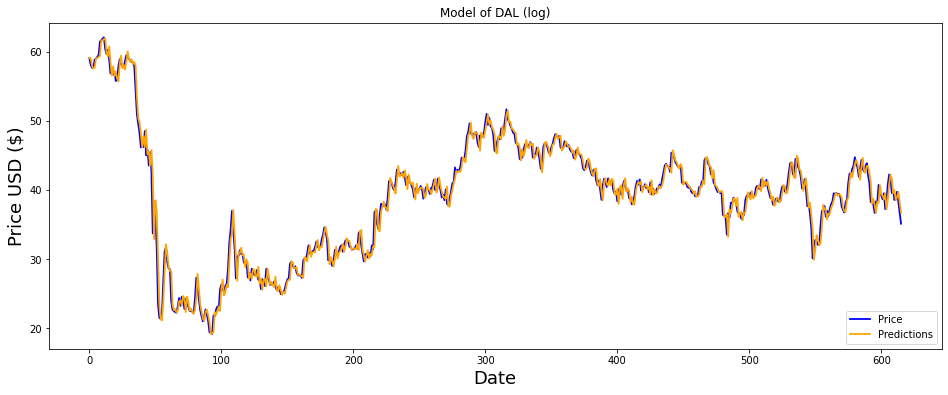

In [130]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model of DAL (log)')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price USD ($)', fontsize=18)
plt.plot(delta_close, label='Price', color = 'b', linewidth=1.8)
plt.plot(pred_delta_exp_full, label='Prediction', color='orange', linewidth=1.8)
plt.legend(['Price', 'Predictions'], loc='lower right')
plt.show()

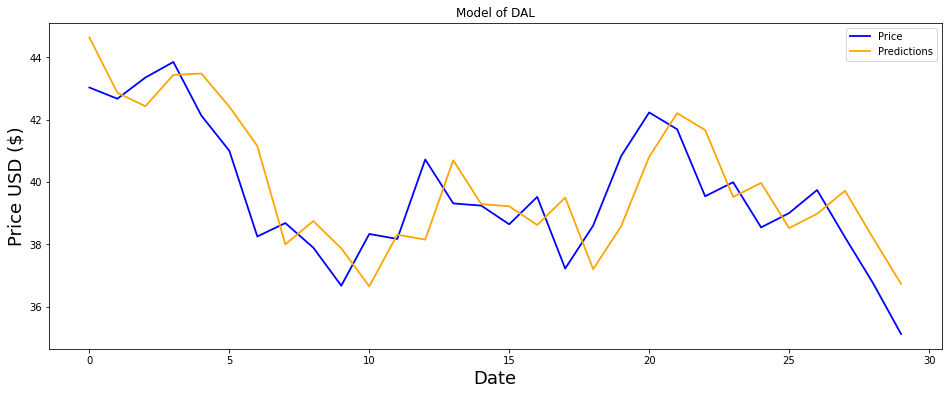

In [131]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model of DAL')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price USD ($)', fontsize=18)
plt.plot(delta_close[training_data_len_delta:], label='Price', color = 'b', linewidth=1.8)
plt.plot(pred_delta_exp_full[training_data_len_delta:], label='Prediction', color='orange', linewidth=1.8)
plt.legend(['Price', 'Predictions'], loc='upper right')
plt.show()

/Users/yuyun/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


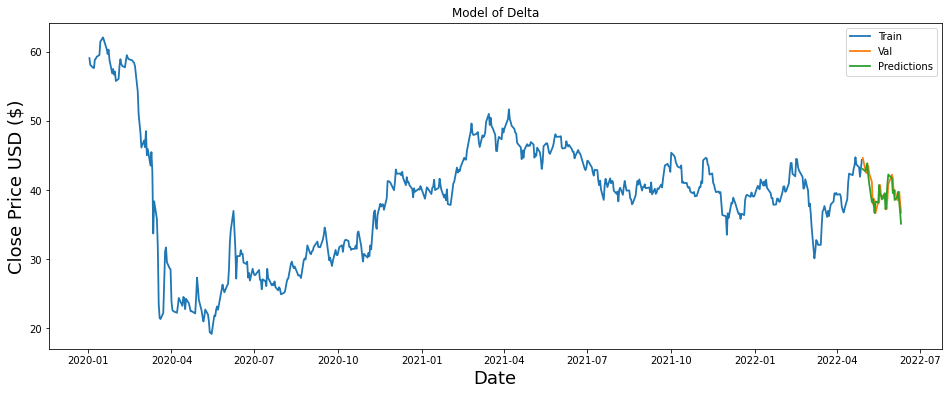

In [132]:
train_delta_arima = df_delta[:training_data_len_delta]
valid_delta_arima = df_delta[training_data_len_delta:]
valid_delta_arima['Predictions'] = pred_delta_exp_full[training_data_len_delta:]
pred_delta_exp_full
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model of Delta')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train_delta_arima['Close'], linewidth=1.8)
plt.plot(valid_delta_arima[['Predictions', 'Close']], linewidth=1.8)
plt.legend(['Train', 'Val', 'Predictions'], loc='upper right')
plt.show()

In [133]:
# Get the root mean squared error (RMSE) of full delta
rmse_delta_log_arima = np.sqrt(np.mean(((pred_delta_exp_full - delta_close) ** 2)))
rmse_delta_log_arima

1.2941128707738716

In [134]:
# Get the root mean squared error (RMSE) of training data
rmse_train_delta_log_arima = np.sqrt(np.mean(((pred_delta_exp_full[0:training_data_len_delta] - delta_close[0:training_data_len_delta]) ** 2)))
rmse_train_delta_log_arima

1.2876069999424988

In [135]:
# Get the root mean squared error (RMSE) of testing data
rmse_test_delta_log_arima = np.sqrt(np.mean(((pred_delta_exp_full[training_data_len_delta:] - delta_close[training_data_len_delta:]) ** 2)))
rmse_test_delta_log_arima

1.4152090136096027

# Result of ARIMA model of stock DAL

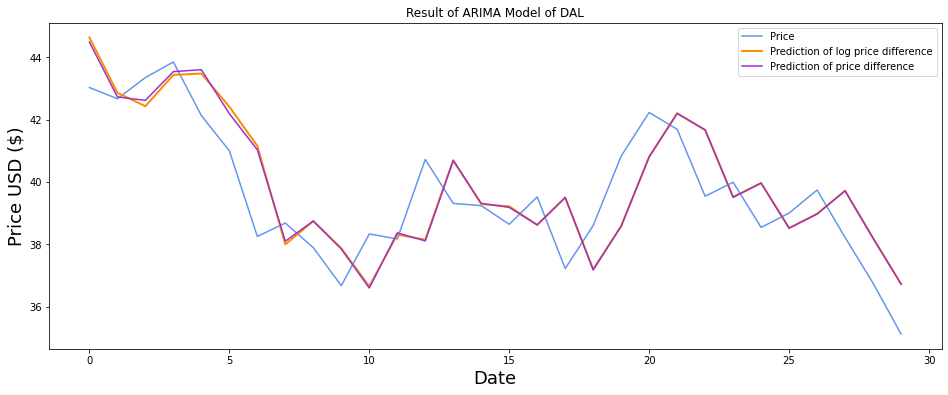

In [136]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Result of ARIMA Model of DAL')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price USD ($)', fontsize=18)
plt.plot(delta_close[training_data_len_delta:], label='Price', color = 'cornflowerblue', linewidth =1.5)
plt.plot(pred_delta_exp_full[training_data_len_delta:], label='Prediction of log price difference', color='darkorange', linewidth =2.0)
plt.plot(pred_delta_arima[training_data_len_delta:], label='Prediction of price difference',color='darkorchid', linewidth =1.5)
plt.legend(['Price', 'Prediction of log price difference','Prediction of price difference'], loc='upper right')
plt.savefig('ARIMA_dal_compare.png', dpi = 500)
plt.show()